<a href="https://colab.research.google.com/github/ICBI/AIMAHEAD_GU/blob/main/Courses/ML_Concepts_in_R/Module_01_Introduction_to_Classification/R_Version_Module_01_Introduction_to_Classification_speedup_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/AAlogo1.jpg" alt="Powered by" width="150"/>

#AI/ML for Healthcare Applications : Lab 1 Introduction to Classification (R notebook)

Based on material from the Georgetown [Health Informatics and Data Science](https://healthinformatics.georgetown.edu) program and licensed under  [CC4.0](https://creativecommons.org/licenses/by/4.0/)

---

#Module 1: Introduction to Classification

The aim of this notebook is to provide an hands-on demo to machine learning in R. <text removed>




The learning objective of this notebook are:
* Learning how to train a basic classification model
* Use the model to make predictions on new unseen data
* Generate a confusion matrix and a classification report
* Learn how to calculate different metrics
* Plot ROC curves
* Try other classifiers and compare models

## Packages



We will start by setting some variables and installing an R package that will help us organize and visualize the data. Other packages will be installed and loaded as necessary.

In [1]:
#system('sudo apt install libudunits2-dev')
#install.packages("caret")

In [2]:
classAgreement <- function (tab, match.names = FALSE)
{
    n <- sum(tab)
    ni <- apply(tab, 1, sum)
    nj <- apply(tab, 2, sum)
    if (match.names && !is.null(dimnames(tab))) {
        lev <- intersect(colnames(tab), rownames(tab))
        p0 <- sum(diag(tab[lev, lev]))/n
        pc <- sum(ni[lev] * nj[lev])/n^2
    }
    else {
        m <- min(length(ni), length(nj))
        p0 <- sum(diag(tab[1:m, 1:m]))/n
        pc <- sum((ni[1:m]/n) * (nj[1:m]/n))
    }
    n2 <- choose(n, 2)
    rand <- 1 + (sum(tab^2) - (sum(ni^2) + sum(nj^2))/2)/n2
    nis2 <- sum(choose(ni[ni > 1], 2))
    njs2 <- sum(choose(nj[nj > 1], 2))
    crand <- (sum(choose(tab[tab > 1], 2)) - (nis2 * njs2)/n2)/((nis2 +
        njs2)/2 - (nis2 * njs2)/n2)
    list(diag = p0, kappa = (p0 - pc)/(1 - pc), rand = rand,
        crand = crand)
}

In [3]:
#' Calculate sensitivity, specificity and predictive values
#'
#' These functions calculate the sensitivity, specificity or predictive values
#' of a measurement system compared to a reference results (the truth or a gold
#' standard). The measurement and "truth" data must have the same two possible
#' outcomes and one of the outcomes must be thought of as a "positive" results.
#'
#' The sensitivity is defined as the proportion of positive results out of the
#' number of samples which were actually positive. When there are no positive
#' results, sensitivity is not defined and a value of \code{NA} is returned.
#' Similarly, when there are no negative results, specificity is not defined
#' and a value of \code{NA} is returned. Similar statements are true for
#' predictive values.
#'
#' The positive predictive value is defined as the percent of predicted
#' positives that are actually positive while the negative predictive value is
#' defined as the percent of negative positives that are actually negative.
#'
#' Suppose a 2x2 table with notation
#'
#' \tabular{rcc}{ \tab Reference \tab \cr Predicted \tab Event \tab No Event
#' \cr Event \tab A \tab B \cr No Event \tab C \tab D \cr }
#'
#' The formulas used here are: \deqn{Sensitivity = A/(A+C)} \deqn{Specificity =
#' D/(B+D)} \deqn{Prevalence = (A+C)/(A+B+C+D)} \deqn{PPV = (sensitivity *
#' Prevalence)/((sensitivity*Prevalence) + ((1-specificity)*(1-Prevalence)))}
#' \deqn{NPV = (specificity * (1-Prevalence))/(((1-sensitivity)*Prevalence) +
#' ((specificity)*(1-Prevalence)))}
#'
#' See the references for discussions of the statistics.
#'
#' @aliases sensitivity sensitivity.default sensitivity.table
#' sensitivity.matrix specificity specificity.default specificity.table
#' specificity.matrix posPredValue posPredValue.default posPredValue.table
#' posPredValue.matrix negPredValue negPredValue.default negPredValue.table
#' negPredValue.matrix
#' @param data for the default functions, a factor containing the discrete
#' measurements. For the \code{table} or \code{matrix} functions, a table or
#' matric object, respectively.
#' @param reference a factor containing the reference values
#' @param positive a character string that defines the factor level
#' corresponding to the "positive" results
#' @param negative a character string that defines the factor level
#' corresponding to the "negative" results
#' @param prevalence a numeric value for the rate of the "positive" class of
#' the data
#' @param na.rm a logical value indicating whether \code{NA} values should be
#' stripped before the computation proceeds
#' @param ... not currently used
#' @return A number between 0 and 1 (or NA).
#' @author Max Kuhn
#' @seealso \code{\link{confusionMatrix}}
#' @references Kuhn, M. (2008), ``Building predictive models in R using the
#' caret package, '' \emph{Journal of Statistical Software},
#' (\doi{10.18637/jss.v028.i05}).
#'
#' Altman, D.G., Bland, J.M. (1994) ``Diagnostic tests 1: sensitivity and
#' specificity,'' \emph{British Medical Journal}, vol 308, 1552.
#'
#' Altman, D.G., Bland, J.M. (1994) ``Diagnostic tests 2: predictive values,''
#' \emph{British Medical Journal}, vol 309, 102.
#' @keywords manip
#' @examples
#'
#' \dontrun{
#' ###################
#' ## 2 class example
#'
#' lvs <- c("normal", "abnormal")
#' truth <- factor(rep(lvs, times = c(86, 258)),
#'                 levels = rev(lvs))
#' pred <- factor(
#'                c(
#'                  rep(lvs, times = c(54, 32)),
#'                  rep(lvs, times = c(27, 231))),
#'                levels = rev(lvs))
#'
#' xtab <- table(pred, truth)
#'
#' sensitivity(pred, truth)
#' sensitivity(xtab)
#' posPredValue(pred, truth)
#' posPredValue(pred, truth, prevalence = 0.25)
#'
#' specificity(pred, truth)
#' negPredValue(pred, truth)
#' negPredValue(xtab)
#' negPredValue(pred, truth, prevalence = 0.25)
#'
#'
#' prev <- seq(0.001, .99, length = 20)
#' npvVals <- ppvVals <- prev  * NA
#' for(i in seq(along.with = prev))
#'   {
#'     ppvVals[i] <- posPredValue(pred, truth, prevalence = prev[i])
#'     npvVals[i] <- negPredValue(pred, truth, prevalence = prev[i])
#'   }
#'
#' plot(prev, ppvVals,
#'      ylim = c(0, 1),
#'      type = "l",
#'      ylab = "",
#'      xlab = "Prevalence (i.e. prior)")
#' points(prev, npvVals, type = "l", col = "red")
#' abline(h=sensitivity(pred, truth), lty = 2)
#' abline(h=specificity(pred, truth), lty = 2, col = "red")
#' legend(.5, .5,
#'        c("ppv", "npv", "sens", "spec"),
#'        col = c("black", "red", "black", "red"),
#'        lty = c(1, 1, 2, 2))
#'
#' ###################
#' ## 3 class example
#'
#' library(MASS)
#'
#' fit <- lda(Species ~ ., data = iris)
#' model <- predict(fit)$class
#'
#' irisTabs <- table(model, iris$Species)
#'
#' ## When passing factors, an error occurs with more
#' ## than two levels
#' sensitivity(model, iris$Species)
#'
#' ## When passing a table, more than two levels can
#' ## be used
#' sensitivity(irisTabs, "versicolor")
#' specificity(irisTabs, c("setosa", "virginica"))
#' }
#'
#' @export sensitivity
sensitivity <-
  function(data, ...){
    UseMethod("sensitivity")
  }

#' @rdname sensitivity
#' @importFrom stats complete.cases
#' @export
"sensitivity.default" <-
  function(data, reference, positive = levels(reference)[1], na.rm = TRUE, ...)
{
  if(!is.factor(reference) | !is.factor(data))
    stop("inputs must be factors")

  ## todo: relax the =2 constraint and let ngative length be > 2
  if(length(unique(c(levels(reference), levels(data)))) != 2)
    stop("input data must have the same two levels")
  if(na.rm)
    {
      cc <- complete.cases(data) & complete.cases(reference)
      if(any(!cc))
        {
          data <- data[cc]
          reference <- reference[cc]
        }
    }
  numer <- sum(data %in% positive & reference %in% positive)
  denom <- sum(reference %in% positive)
  sens <- ifelse(denom > 0, numer / denom, NA)
  sens
}

#' @rdname sensitivity
#' @export
"sensitivity.table" <-
  function(data, positive = rownames(data)[1], ...)
{
  ## "truth" in columns, predictions in rows
  if(!all.equal(nrow(data), ncol(data))) stop("the table must have nrow = ncol")
  if(!all.equal(rownames(data), colnames(data))) stop("the table must the same groups in the same order")

  if(nrow(data) > 2)
    {
      tmp <- data
      data <- matrix(NA, 2, 2)

      colnames(data) <- rownames(data) <- c("pos", "neg")
      posCol <- which(colnames(tmp) %in% positive)
      negCol <- which(!(colnames(tmp) %in% positive))

      data[1, 1] <- sum(tmp[posCol, posCol])
      data[1, 2] <- sum(tmp[posCol, negCol])
      data[2, 1] <- sum(tmp[negCol, posCol])
      data[2, 2] <- sum(tmp[negCol, negCol])
      data <- as.table(data)
      positive <- "pos"
      rm(tmp)
    }

  numer <- sum(data[positive, positive])
  denom <- sum(data[, positive])
  sens <- ifelse(denom > 0, numer / denom, NA)
  sens
}

#' @rdname sensitivity
#' @export
"sensitivity.matrix" <-
  function(data, positive = rownames(data)[1], ...)
{
  data <- as.table(data)
  sensitivity.table(data)
}


In [4]:
#' @export
#' @rdname sensitivity
specificity <-
  function(data, ...){
    UseMethod("specificity")
  }

#' @importFrom stats complete.cases
#' @export
#' @rdname sensitivity
"specificity.default" <-
function(data, reference, negative = levels(reference)[-1], na.rm = TRUE, ...)
{
   if(!is.factor(reference) | !is.factor(data))
      stop("input data must be a factor")

   ## todo: relax the =2 constraint and let ngative length be > 2
   if(length(unique(c(levels(reference), levels(data)))) != 2)
      stop("input data must have the same two levels")
   if(na.rm)
     {
       cc <- complete.cases(data) & complete.cases(reference)
       if(any(!cc))
         {
           data <- data[cc]
           reference <- reference[cc]
         }
     }
   numer <- sum(data %in% negative & reference %in% negative)
   denom <- sum(reference %in% negative)
   spec <- ifelse(denom > 0, numer / denom, NA)
   spec
}

#' @export
#' @rdname sensitivity
"specificity.table" <-
  function(data, negative = rownames(data)[-1], ...)
{
  ## "truth" in columns, predictions in rows
  if(!all.equal(nrow(data), ncol(data))) stop("the table must have nrow = ncol")
  if(!all.equal(rownames(data), colnames(data))) stop("the table must the same groups in the same order")

  if(nrow(data) > 2)
    {
      tmp <- data
      data <- matrix(NA, 2, 2)

      colnames(data) <- rownames(data) <- c("pos", "neg")
      negCol <- which(colnames(tmp) %in% negative)
      posCol <- which(!(colnames(tmp) %in% negative))

      data[1, 1] <- sum(tmp[posCol, posCol])
      data[1, 2] <- sum(tmp[posCol, negCol])
      data[2, 1] <- sum(tmp[negCol, posCol])
      data[2, 2] <- sum(tmp[negCol, negCol])
      data <- as.table(data)
      negative <- "neg"
      rm(tmp)
    }

  numer <- sum(data[negative, negative])
  denom <- sum(data[, negative])
  spec <- ifelse(denom > 0, numer / denom, NA)
  spec
}

#' @export
"specificity.matrix" <-
  function(data, negative = rownames(data)[-1], ...)
{
  data <- as.table(data)
  specificity.table(data)
}


In [5]:
#' Create a confusion matrix
#'
#' Calculates a cross-tabulation of observed and predicted classes with
#' associated statistics.
#'
#' The functions requires that the factors have exactly the same levels.
#'
#' For two class problems, the sensitivity, specificity, positive predictive
#' value and negative predictive value is calculated using the \code{positive}
#' argument. Also, the prevalence of the "event" is computed from the data
#' (unless passed in as an argument), the detection rate (the rate of true
#' events also predicted to be events) and the detection prevalence (the
#' prevalence of predicted events).
#'
#' Suppose a 2x2 table with notation
#'
#' \tabular{rcc}{ \tab Reference \tab \cr Predicted \tab Event \tab No Event
#' \cr Event \tab A \tab B \cr No Event \tab C \tab D \cr }
#'
#' The formulas used here are: \deqn{Sensitivity = A/(A+C)} \deqn{Specificity =
#' D/(B+D)} \deqn{Prevalence = (A+C)/(A+B+C+D)} \deqn{PPV = (sensitivity *
#' prevalence)/((sensitivity*prevalence) + ((1-specificity)*(1-prevalence)))}
#' \deqn{NPV = (specificity * (1-prevalence))/(((1-sensitivity)*prevalence) +
#' ((specificity)*(1-prevalence)))} \deqn{Detection Rate = A/(A+B+C+D)}
#' \deqn{Detection Prevalence = (A+B)/(A+B+C+D)} \deqn{Balanced Accuracy =
#' (sensitivity+specificity)/2}
#'
#' \deqn{Precision = A/(A+B)} \deqn{Recall = A/(A+C)} \deqn{F1 =
#' (1+beta^2)*precision*recall/((beta^2 * precision)+recall)}
#'
#' where \code{beta = 1} for this function.
#'
#' See the references for discussions of the first five formulas.
#'
#' For more than two classes, these results are calculated comparing each
#' factor level to the remaining levels (i.e. a "one versus all" approach).
#'
#' The overall accuracy and unweighted Kappa statistic are calculated. A
#' p-value from McNemar's test is also computed using
#' \code{\link[stats]{mcnemar.test}} (which can produce \code{NA} values with
#' sparse tables).
#'
#' The overall accuracy rate is computed along with a 95 percent confidence
#' interval for this rate (using \code{\link[stats]{binom.test}}) and a
#' one-sided test to see if the accuracy is better than the "no information
#' rate," which is taken to be the largest class percentage in the data.
#'
#' @aliases confusionMatrix.table confusionMatrix.default confusionMatrix
#' @param data a factor of predicted classes (for the default method) or an
#' object of class \code{\link[base]{table}}.
#' @param reference a factor of classes to be used as the true results
#' @param positive an optional character string for the factor level that
#' corresponds to a "positive" result (if that makes sense for your data). If
#' there are only two factor levels, the first level will be used as the
#' "positive" result. When \code{mode = "prec_recall"}, \code{positive} is the
#' same value used for \code{relevant} for functions \code{\link{precision}},
#' \code{\link{recall}}, and \code{\link{F_meas.table}}.
#' @param dnn a character vector of dimnames for the table
#' @param prevalence a numeric value or matrix for the rate of the "positive"
#' class of the data. When \code{data} has two levels, \code{prevalence} should
#' be a single numeric value. Otherwise, it should be a vector of numeric
#' values with elements for each class. The vector should have names
#' corresponding to the classes.
#' @param mode a single character string either "sens_spec", "prec_recall", or
#' "everything"
#' @param \dots options to be passed to \code{table}. NOTE: do not include
#' \code{dnn} here
#' @return a list with elements \item{table}{the results of \code{table} on
#' \code{data} and \code{reference}} \item{positive}{the positive result level}
#' \item{overall}{a numeric vector with overall accuracy and Kappa statistic
#' values} \item{byClass}{the sensitivity, specificity, positive predictive
#' value, negative predictive value, precision, recall, F1, prevalence,
#' detection rate, detection prevalence and balanced accuracy for each class.
#' For two class systems, this is calculated once using the \code{positive}
#' argument}
#' @note If the reference and data factors have the same levels, but in the
#' incorrect order, the function will reorder them to the order of the data and
#' issue a warning.
#' @author Max Kuhn
#' @seealso \code{\link{as.table.confusionMatrix}},
#' \code{\link{as.matrix.confusionMatrix}}, \code{\link{sensitivity}},
#' \code{\link{specificity}}, \code{\link{posPredValue}},
#' \code{\link{negPredValue}}, \code{\link{print.confusionMatrix}},
#' \code{\link[stats]{binom.test}}
#' @references Kuhn, M. (2008), ``Building predictive models in R using the
#' caret package, '' \emph{Journal of Statistical Software},
#' (\doi{10.18637/jss.v028.i05}).
#'
#' Altman, D.G., Bland, J.M. (1994) ``Diagnostic tests 1: sensitivity and
#' specificity,'' \emph{British Medical Journal}, vol 308, 1552.
#'
#' Altman, D.G., Bland, J.M. (1994) ``Diagnostic tests 2: predictive values,''
#' \emph{British Medical Journal}, vol 309, 102.
#'
#' Velez, D.R., et. al. (2008) ``A balanced accuracy function for epistasis
#' modeling in imbalanced datasets using multifactor dimensionality
#' reduction.,'' \emph{Genetic Epidemiology}, vol 4, 306.
#' @keywords utilities
#' @examples
#'
#' ###################
#' ## 2 class example
#'
#' lvs <- c("normal", "abnormal")
#' truth <- factor(rep(lvs, times = c(86, 258)),
#'                 levels = rev(lvs))
#' pred <- factor(
#'                c(
#'                  rep(lvs, times = c(54, 32)),
#'                  rep(lvs, times = c(27, 231))),
#'                levels = rev(lvs))
#'
#' xtab <- table(pred, truth)
#'
#' confusionMatrix(xtab)
#' confusionMatrix(pred, truth)
#' confusionMatrix(xtab, prevalence = 0.25)
#'
#' ###################
#' ## 3 class example
#'
#' confusionMatrix(iris$Species, sample(iris$Species))
#'
#' newPrior <- c(.05, .8, .15)
#' names(newPrior) <- levels(iris$Species)
#'
#' confusionMatrix(iris$Species, sample(iris$Species))
#'
#'
#' @export confusionMatrix
confusionMatrix <-
  function(data, ...){
    UseMethod("confusionMatrix")
  }

#' @rdname confusionMatrix
#' @method confusionMatrix default
#' @importFrom utils getFromNamespace
#' @export
confusionMatrix.default <- function(data, reference,
                                    positive = NULL,
                                    dnn = c("Prediction", "Reference"),
                                    prevalence = NULL,
                                    mode = "sens_spec",
                                    ...) {
  if(!(mode %in% c("sens_spec", "prec_recall", "everything")))
    stop("`mode` should be either 'sens_spec', 'prec_recall', or 'everything'")
  if(!is.factor(data) | !is.factor(reference)) {
    stop("`data` and `reference` should be factors with the same levels.", call. = FALSE)
  }
  if(!is.character(positive) & !is.null(positive)) stop("positive argument must be character")

  if(length(levels(data)) > length(levels(reference)))
    stop("the data cannot have more levels than the reference")

  if(!any(levels(data) %in% levels(reference))){
    stop("The data must contain some levels that overlap the reference.")
  }

  if(!all(levels(data) %in% levels(reference))){
    badLevel <- levels(data)[!levels(data) %in% levels(reference)]
    if(sum(table(data)[badLevel]) > 0){
      stop("The data contain levels not found in the data.")
    } else{
      warning("The data contains levels not found in the data, but they are empty and will be dropped.")
      data <- factor(as.character(data))
    }
  }

  if(any(levels(reference) != levels(data))) {
    warning("Levels are not in the same order for reference and data. Refactoring data to match.")
    data <- as.character(data)
    data <- factor(data, levels = levels(reference))
  }
  classLevels <- levels(data)
  numLevels <- length(classLevels)
  if(numLevels < 2)
    stop("there must be at least 2 factors levels in the data")

  if(numLevels == 2 & is.null(positive))  positive <- levels(reference)[1]

  classTable <- table(data, reference, dnn = dnn, ...)

  #getFromNamespace("confusionMatrix.table", "caret")(classTable, positive, prevalence = prevalence, mode = mode)
  confusionMatrix.table(classTable, positive, prevalence = prevalence, mode = mode)
}

#' @rdname confusionMatrix
#' @method confusionMatrix matrix
#' @importFrom utils getFromNamespace
#' @export
confusionMatrix.matrix <- function(data,
                                   positive = NULL,
                                   prevalence = NULL,
                                   mode = "sens_spec",
                                   ...) {
  if (length(unique(dim(data))) != 1) {
    stop("matrix must have equal dimensions")
  }
  classTable <- as.table(data, ...)
  confusionMatrix(classTable, positive, prevalence = prevalence, mode = mode)
}

#' @rdname confusionMatrix
#' @importFrom stats binom.test mcnemar.test
#' @export
confusionMatrix.table <- function(data, positive = NULL,
                                  prevalence = NULL, mode = "sens_spec", ...){
  if(!(mode %in% c("sens_spec", "prec_recall", "everything")))
    stop("`mode` should be either 'sens_spec', 'prec_recall', or 'everything'")
  if(length(dim(data)) != 2) stop("the table must have two dimensions")
  if(!all.equal(nrow(data), ncol(data))) stop("the table must nrow = ncol")
  if(!isTRUE(all.equal(rownames(data), colnames(data)))) stop("the table must the same classes in the same order")
  if(!is.character(positive) & !is.null(positive)) stop("positive argument must be character")

  classLevels <- rownames(data)
  numLevels <- length(classLevels)
  if(numLevels < 2)
    stop("there must be at least 2 factors levels in the data")

  if(numLevels == 2 & is.null(positive))  positive <- rownames(data)[1]


  if(numLevels == 2 & !is.null(prevalence) && length(prevalence) != 1)
    stop("with two levels, one prevalence probability must be specified")

  if(numLevels > 2 & !is.null(prevalence) && length(prevalence) != numLevels)
    stop("the number of prevalence probability must be the same as the number of levels")

  if(numLevels > 2 & !is.null(prevalence) && is.null(names(prevalence)))
    stop("with >2 classes, the prevalence vector must have names")

  propCI <- function(x) {
    res <- try(binom.test(sum(diag(x)), sum(x))$conf.int, silent = TRUE)
    if(inherits(res, "try-error"))
      res <- rep(NA, 2)
    res
  }

  propTest <- function(x){
    res <- try(
      binom.test(sum(diag(x)),
                 sum(x),
                 p = max(apply(x, 2, sum)/sum(x)),
                 alternative = "greater"),
      silent = TRUE)
    res <- if(inherits(res, "try-error"))
      c("null.value.probability of success" = NA, p.value = NA)
    else
      res <- unlist(res[c("null.value", "p.value")])
    res
  }

  #overall <- c(unlist(e1071::classAgreement(data))[c("diag", "kappa")],
  #             propCI(data),
  #             propTest(data),
  #             mcnemar.test(data)$p.value)
  overall <- c(classAgreement(data)[c("diag", "kappa")],
               propCI(data),
               propTest(data),
               mcnemar.test(data)$p.value)
  overall <- as.numeric(overall)

  names(overall) <- c("Accuracy", "Kappa", "AccuracyLower", "AccuracyUpper", "AccuracyNull", "AccuracyPValue", "McnemarPValue")

  if(numLevels == 2) {
    if(is.null(prevalence)) prevalence <- sum(data[, positive])/sum(data)
    negative <- classLevels[!(classLevels %in% positive)]
    tableStats <- c(sensitivity.table(data, positive),
                    specificity.table(data, negative),
                    posPredValue.table(data, positive, prevalence = prevalence),
                    negPredValue.table(data, negative, prevalence = prevalence),
                    precision.table(data, relevant = positive),
                    recall.table(data, relevant = positive),
                    F_meas.table(data, relevant = positive),
                    prevalence,
                    sum(data[positive, positive])/sum(data),
                    sum(data[positive, ])/sum(data))
    names(tableStats) <- c("Sensitivity", "Specificity",
                           "Pos Pred Value", "Neg Pred Value",
                           "Precision", "Recall", "F1",
                           "Prevalence", "Detection Rate",
                           "Detection Prevalence")
    tableStats["Balanced Accuracy"] <- (tableStats["Sensitivity"]+tableStats["Specificity"])/2

  } else {

    tableStats <- matrix(NA, nrow = length(classLevels), ncol = 11)

    for(i in seq(along.with = classLevels)) {
      pos <- classLevels[i]
      neg <- classLevels[!(classLevels %in% classLevels[i])]
      prev <- if(is.null(prevalence)) sum(data[, pos])/sum(data) else prevalence[pos]
      tableStats[i,] <- c(sensitivity.table(data, pos),
                          specificity.table(data, neg),
                          posPredValue.table(data, pos, prevalence = prev),
                          negPredValue.table(data, neg, prevalence = prev),
                          precision.table(data, relevant = pos),
                          recall.table(data, relevant = pos),
                          F_meas.table(data, relevant = pos),
                          prev,
                          sum(data[pos, pos])/sum(data),
                          sum(data[pos, ])/sum(data), NA)
      tableStats[i,11] <- (tableStats[i,1] + tableStats[i,2])/2
    }
    rownames(tableStats) <- paste("Class:", classLevels)
    colnames(tableStats) <- c("Sensitivity", "Specificity",
                              "Pos Pred Value", "Neg Pred Value",
                              "Precision", "Recall", "F1",
                              "Prevalence", "Detection Rate",
                              "Detection Prevalence", "Balanced Accuracy")
  }

  structure(
    list(positive = positive,
         table = data,
         overall = overall,
         byClass = tableStats,
         mode = mode,
         dots = list(...)),
    class = "confusionMatrix")
}

#' Confusion matrix as a table
#' @name as.matrix.confusionMatrix
#' @aliases as.table.confusionMatrix
#' @description Conversion functions for class \code{confusionMatrix}
#'
#' @param x an object of class \code{\link{confusionMatrix}}
#' @param what data to convert to matrix. Either \code{"xtabs"}, \code{"overall"} or  \code{"classes"}
#' @param \dots not currently used
#'
#' @details For \code{as.table}, the cross-tabulations are saved. For \code{as.matrix}, the three object types are saved in matrix format.
#'
#' @return A matrix or table
#'
#' @author Max Kuhn
#'
#' @examples
#' ###################
#' ## 2 class example
#'
#' lvs <- c("normal", "abnormal")
#' truth <- factor(rep(lvs, times = c(86, 258)),
#'                 levels = rev(lvs))
#' pred <- factor(
#'                c(
#'                  rep(lvs, times = c(54, 32)),
#'                  rep(lvs, times = c(27, 231))),
#'                levels = rev(lvs))
#'
#' xtab <- table(pred, truth)
#'
#' results <- confusionMatrix(xtab)
#' as.table(results)
#' as.matrix(results)
#' as.matrix(results, what = "overall")
#' as.matrix(results, what = "classes")
#'
#' ###################
#' ## 3 class example
#'
#' xtab <- confusionMatrix(iris$Species, sample(iris$Species))
#' as.matrix(xtab)
#'
#' @keywords utilities
#'
#' @export
as.matrix.confusionMatrix <- function(x, what = "xtabs", ...){
  if(!(what %in% c("xtabs", "overall", "classes")))
    stop("what must be either xtabs, overall or classes")
  out <- switch(what,
                xtabs = matrix(as.vector(x$table),
                               nrow = length(colnames(x$table)),
                               dimnames = list(rownames(x$table), colnames(x$table))),
                overall = as.matrix(x$overall),
                classes = as.matrix(x$byClass))
  if(what == "classes"){
    if(length(colnames(x$table)) > 2){
      out <- t(out)
      colnames(out) <- gsub("Class: ", "", colnames(out), fixed = TRUE)
    }
  }
  out
}

sbf_resampledCM <- function(x) {
  lev <- x$obsLevels
  if("pred" %in% names(x) && !is.null(x$pred)) {
    resampledCM <- do.call("rbind", x$pred[names(x$pred) == "predictions"])
    resampledCM <- ddply(resampledCM, .(Resample), function(y) flatTable(pred  = y$pred, obs = y$obs))
  } else stop(paste("When there are 50+ classes, the function does not automatically pre-compute the",
                    "resampled confusion matrices. You can get them when the option",
                    "`saveDetails = TRUE`."))
  resampledCM
}
rfe_resampledCM <- function(x) {
  lev <- x$obsLevels
  if("resample" %in% names(x) &&
     !is.null(x$resample) &&
     sum(grepl("\\.cell[1-9]", names(x$resample))) > 3) {
    resampledCM <- subset(x$resample, Variables == x$optsize)
    resampledCM <- resampledCM[,grepl("\\.cell[1-9]", names(resampledCM))]
  } else {
    if(!is.null(x$pred)) {
      resampledCM <- ddply(x$pred, .(Resample), function(y) flatTable(pred  = y$pred, obs = y$obs))
    } else {
      if(length(lev) > 50)
        stop(paste("When there are 50+ classes, `the function does not automatically pre-compute the",
                   "resampled confusion matrices. You can get them when the object",
                   "has a `pred` element."))
    }
  }
  resampledCM
}
train_resampledCM <- function(x) {
  if(x$modelType == "Regression")
    stop("confusion matrices are only valid for classification models")

  lev <- levels(x)

  ## For problems with large numbers of classes, `train`, `rfe`, and `sbf` do not pre-compute the
  ## the resampled matrices. If the predictions have been saved, we can get them from there.

  if("resampledCM" %in% names(x) && !is.null(x$resampledCM)) {
    ## get only best tune
    names(x$bestTune) <- gsub("^\\.", "", names(x$bestTune))
    resampledCM <- merge(x$bestTune, x$resampledCM)
  } else {
    if(!is.null(x$pred)) {
      resampledCM <- ddply(merge(x$pred, x$bestTune), .(Resample), function(y) flatTable(pred  = y$pred, obs = y$obs))
    } else {
      if(length(lev) > 50)
        stop(paste("When there are 50+ classes, `train` does not automatically pre-compute the",
                   "resampled confusion matrices. You can get them from this function",
                   "using a value of `savePredictions` other than FALSE."))
    }
  }
  resampledCM
}


#' @export
as.table.confusionMatrix <- function(x, ...)  x$table



#' Estimate a Resampled Confusion Matrix
#'
#' Using a \code{\link{train}}, \code{\link{rfe}}, \code{\link{sbf}} object,
#' determine a confusion matrix based on the resampling procedure
#'
#' When \code{\link{train}} is used for tuning a model, it tracks the confusion
#' matrix cell entries for the hold-out samples. These can be aggregated and
#' used for diagnostic purposes. For \code{\link{train}}, the matrix is
#' estimated for the final model tuning parameters determined by
#' \code{\link{train}}. For \code{\link{rfe}}, the matrix is associated with
#' the optimal number of variables.
#'
#' There are several ways to show the table entries. Using \code{norm = "none"}
#' will show the aggregated counts of samples on each of the cells (across all
#' resamples). For \code{norm = "average"}, the average number of cell counts
#' across resamples is computed (this can help evaluate how many holdout
#' samples there were on average). The default is \code{norm = "overall"},
#' which is equivalento to \code{"average"} but in percentages.
#'
#' @aliases confusionMatrix.train confusionMatrix.rfe confusionMatrix.sbf
#' @param data An object of class \code{\link{train}}, \code{\link{rfe}},
#' \code{\link{sbf}} that did not use out-of-bag resampling or leave-one-out
#' cross-validation.
#' @param norm A character string indicating how the table entries should be
#' normalized. Valid values are "none", "overall" or "average".
#' @param dnn A character vector of dimnames for the table
#' @param \dots not used here
#' @return a list of class \code{confusionMatrix.train},
#' \code{confusionMatrix.rfe} or \code{confusionMatrix.sbf} with elements
#' \item{table}{the normalized matrix} \item{norm}{an echo fo the call}
#' \item{text}{a character string with details about the resampling procedure
#' (e.g. "Bootstrapped (25 reps) Confusion Matrix"}
#' @author Max Kuhn
#' @seealso \code{\link{confusionMatrix}}, \code{\link{train}},
#' \code{\link{rfe}}, \code{\link{sbf}}, \code{\link{trainControl}}
#' @keywords utilities
#' @export
#' @examples
#'
#'
#' data(iris)
#' TrainData <- iris[,1:4]
#' TrainClasses <- iris[,5]
#'
#' knnFit <- train(TrainData, TrainClasses,
#'                 method = "knn",
#'                 preProcess = c("center", "scale"),
#'                 tuneLength = 10,
#'                 trControl = trainControl(method = "cv"))
#' confusionMatrix(knnFit)
#' confusionMatrix(knnFit, "average")
#' confusionMatrix(knnFit, "none")
#'
#'
#' @export confusionMatrix.train
confusionMatrix.train <- function(data, norm = "overall", dnn = c("Prediction", "Reference"), ...){
  if(data$control$method %in% c("oob", "LOOCV", "none"))
    stop("cannot compute confusion matrices for leave-one-out, out-of-bag resampling, or no resampling")

  if (inherits(data, "train")) {
    if(data$modelType == "Regression")
      stop("confusion matrices are only valid for classification models")
    lev <- levels(data)
    ## For problems with large numbers of classes, `train`, `rfe`, and `sbf` do not pre-compute the
    ## the resampled matrices. If the predictions have been saved, we can get them from there.
    resampledCM <- train_resampledCM(data)
  } else {
    lev <- data$obsLevels
    if (inherits(data, "rfe")) resampledCM <- rfe_resampledCM(data)
    if (inherits(data, "sbf")) resampledCM <- sbf_resampledCM(data)
  }

  if(!is.null(data$control$index)) {
    resampleN <- unlist(lapply(data$control$index, length))
    numResamp <- length(resampleN)
    resampText <- resampName(data)
  } else {
    resampText <- ""
    numResamp <- 0
  }

  counts <- as.matrix(resampledCM[ , grep("^\\.?cell", colnames(resampledCM))])

  ## normalize?
  norm <- match.arg(norm, c("none", "overall", "average"))

  if(norm == "none") counts <- matrix(apply(counts, 2, sum), nrow = length(lev))
  else counts <- matrix(apply(counts, 2, mean), nrow = length(lev))

  if(norm == "overall") counts <- counts / sum(counts) * 100

  ## names
  rownames(counts) <- colnames(counts) <- lev
  names(dimnames(counts)) <- dnn

  ## out
  out <- list(table = as.table(counts),
              norm = norm,
              B = length(data$control$index),
              text = paste(resampText, "Confusion Matrix"))
  class(out) <- paste0("confusionMatrix.", class(data))
  out
}

#' @export
confusionMatrix.rfe <- confusionMatrix.train

#' @export
confusionMatrix.sbf <- confusionMatrix.train

#' @importFrom utils getFromNamespace
#' @method print confusionMatrix.train
#' @export
print.confusionMatrix.train <- function(x, digits = 1, ...){
  cat(x$text, "\n")
  normText <- switch(x$norm,
                     none = "\n(entries are un-normalized aggregated counts)\n",
                     average = "\n(entries are average cell counts across resamples)\n",
                     overall = "\n(entries are percentual average cell counts across resamples)\n",
                     "")
  cat(normText, "\n")
  if(x$norm == "none" & x$B == 1) {
    #print(getFromNamespace("confusionMatrix.table", "caret")(x$table))
    print(confusionMatrix.table(x$table))
  } else {
    print(round(x$table, digits))

    out <- cbind("Accuracy (average)", ":", formatC(sum(diag(x$table) / sum(x$table))))

    dimnames(out) <- list(rep("", nrow(out)), rep("", ncol(out)))
    print(out, quote = FALSE)
    cat("\n")
  }
  invisible(x)
}

#' @method print confusionMatrix.rfe
#' @export
print.confusionMatrix.rfe <- print.confusionMatrix.train

#' @method print confusionMatrix.sbf
#' @export
print.confusionMatrix.sbf <- print.confusionMatrix.train

resampName <- function(x, numbers = TRUE){
  if(!("control" %in% names(x))) return("")
  if(numbers) {
    resampleN <- unlist(lapply(x$control$index, length))
    numResamp <- length(resampleN)
    out <- switch(tolower(x$control$method),
                  none = "None",
                  apparent = "Apparent",
                  custom = paste("Custom Resampling (", numResamp, " reps)", sep = ""),
                  timeslice = paste("Rolling Forecasting Origin Resampling (",
                                    x$control$horizon, " held-out with",
                                    ifelse(x$control$fixedWindow, " a ", " no "),
                                    "fixed window)", sep = ""),
                  oob = "Out of Bag Resampling",
                  boot =, optimism_boot =, boot_all =,
                  boot632 = paste("Bootstrapped (", numResamp, " reps)", sep = ""),
                  cv = paste("Cross-Validated (", x$control$number, " fold)", sep = ""),
                  repeatedcv = paste("Cross-Validated (", x$control$number, " fold, repeated ",
                                     x$control$repeats, " times)", sep = ""),
                  lgocv = paste("Repeated Train/Test Splits Estimated (", numResamp, " reps, ",
                                round(x$control$p*100, 1), "%)", sep = ""),
                  loocv = "Leave-One-Out Cross-Validation",
                  adaptive_boot = paste("Adaptively Bootstrapped (", numResamp, " reps)", sep = ""),
                  adaptive_cv = paste("Adaptively Cross-Validated (", x$control$number, " fold, repeated ",
                                      x$control$repeats, " times)", sep = ""),
                  adaptive_lgocv = paste("Adaptive Repeated Train/Test Splits Estimated (", numResamp, " reps, ",
                                         round(x$control$p, 2), "%)", sep = "")
    )
  } else {
    out <- switch(tolower(x$control$method),
                  none = "None",
                  apparent = "(Apparent)",
                  custom = "Custom Resampling",
                  timeslice = "Rolling Forecasting Origin Resampling",
                  oob = "Out of Bag Resampling",
                  boot = "(Bootstrap)",
                  optimism_boot = "(Optimism Bootstrap)",
                  boot_all = "(Bootstrap All)",
                  boot632 = "(Bootstrap 632 Rule)",
                  cv = "(Cross-Validation)",
                  repeatedcv = "(Repeated Cross-Validation)",
                  loocv = "Leave-One-Out Cross-Validation",
                  lgocv = "(Repeated Train/Test Splits)")

  }
  out
}


#' Print method for confusionMatrix
#'
#' a print method for \code{confusionMatrix}
#'
#'
#' @param x an object of class \code{confusionMatrix}
#' @param mode a single character string either "sens_spec", "prec_recall", or
#' "everything"
#' @param digits number of significant digits when printed
#' @param printStats a logical: if \code{TRUE} then table statistics are also
#' printed
#' @param \dots optional arguments to pass to \code{print.table}
#' @return \code{x} is invisibly returned
#' @author Max Kuhn
#' @seealso \code{\link{confusionMatrix}}
#' @keywords utilities
#' @export

print.confusionMatrix <- function(x, mode = x$mode, digits = max(3, getOption("digits") - 3), printStats = TRUE, ...){
  if(is.null(mode)) mode <- "sens_spec"
  if(!(mode %in% c("sens_spec", "prec_recall", "everything")))
    stop("`mode` should be either 'sens_spec', 'prec_recall', or 'everything'")
  cat("Confusion Matrix and Statistics\n\n")
  print(x$table, ...)

  if(printStats) {
    tmp <- round(x$overall, digits = digits)
    pIndex <- grep("PValue", names(x$overall))
    tmp[pIndex] <- format.pval(x$overall[pIndex], digits = digits)
    overall <- tmp

    accCI <- paste("(",
                   paste(
                     overall[ c("AccuracyLower", "AccuracyUpper")],
                     collapse = ", "),
                   ")",
                   sep = "")

    overallText <- c(paste(overall["Accuracy"]),
                     accCI,
                     paste(overall[c("AccuracyNull", "AccuracyPValue")]),
                     "",
                     paste(overall["Kappa"]),
                     "",
                     paste(overall["McnemarPValue"]))

    overallNames <- c("Accuracy", "95% CI",
                      "No Information Rate",
                      "P-Value [Acc > NIR]",
                      "",
                      "Kappa",
                      "",
                      "Mcnemar's Test P-Value")

    if(dim(x$table)[1] > 2){
      cat("\nOverall Statistics\n")
      overallNames <- ifelse(overallNames == "",
                             "",
                             paste(overallNames, ":"))
      out <- cbind(format(overallNames, justify = "right"), overallText)
      colnames(out) <- rep("", ncol(out))
      rownames(out) <- rep("", nrow(out))

      print(out, quote = FALSE)

      cat("\nStatistics by Class:\n\n")
      if(mode == "prec_recall")
        x$byClass <- x$byClass[,!grepl("(Sensitivity)|(Specificity)|(Pos Pred Value)|(Neg Pred Value)",
                                     colnames(x$byClass))]
      if(mode == "sens_spec")
        x$byClass <- x$byClass[,!grepl("(Precision)|(Recall)|(F1)", colnames(x$byClass))]
      print(t(x$byClass), digits = digits)

    } else {
      if(mode == "prec_recall")
        x$byClass <- x$byClass[!grepl("(Sensitivity)|(Specificity)|(Pos Pred Value)|(Neg Pred Value)",
                                       names(x$byClass))]
      if(mode == "sens_spec")
        x$byClass <- x$byClass[!grepl("(Precision)|(Recall)|(F1)", names(x$byClass))]

      overallText <- c(overallText,
                       "",
                       format(x$byClass, digits = digits))
      overallNames <- c(overallNames, "", names(x$byClass))
      overallNames <- ifelse(overallNames == "", "", paste(overallNames, ":"))

      overallNames <- c(overallNames, "", "'Positive' Class :")
      overallText <- c(overallText, "", x$positive)

      out <- cbind(format(overallNames, justify = "right"), overallText)
      colnames(out) <- rep("", ncol(out))
      rownames(out) <- rep("", nrow(out))

      out <- rbind(out, rep("", 2))

      print(out, quote = FALSE)
    }
  }
  invisible(x)
}


In [6]:
#' @rdname sensitivity
#' @export
posPredValue <-
  function(data, ...){
    UseMethod("posPredValue")
  }

#' @rdname sensitivity
#' @export
"posPredValue.default" <-
  function(data, reference, positive = levels(reference)[1], prevalence = NULL, ...)
{
  if(!is.factor(reference) | !is.factor(data))
    stop("inputs must be factors")

  if(length(unique(c(levels(reference), levels(data)))) != 2)
    stop("input data must have the same two levels")

  lvls <- levels(data)
  if(is.null(prevalence)) prevalence <- mean(reference == positive)
  sens <- sensitivity(data, reference, positive)
  spec <- specificity(data, reference, lvls[lvls != positive])
  (sens * prevalence)/((sens*prevalence) + ((1-spec)*(1-prevalence)))

}

#' @rdname sensitivity
#' @export
"posPredValue.table" <-
  function(data, positive = rownames(data)[1], prevalence = NULL, ...)
{
  ## "truth" in columns, predictions in rows
  if(!all.equal(nrow(data), ncol(data))) stop("the table must have nrow = ncol")
  if(!all.equal(rownames(data), colnames(data))) stop("the table must the same groups in the same order")

  if(nrow(data) > 2)
    {
      tmp <- data
      data <- matrix(NA, 2, 2)

      colnames(data) <- rownames(data) <- c("pos", "neg")
      posCol <- which(colnames(tmp) %in% positive)
      negCol <- which(!(colnames(tmp) %in% positive))

      data[1, 1] <- sum(tmp[posCol, posCol])
      data[1, 2] <- sum(tmp[posCol, negCol])
      data[2, 1] <- sum(tmp[negCol, posCol])
      data[2, 2] <- sum(tmp[negCol, negCol])
      data <- as.table(data)
      positive <- "pos"
      rm(tmp)
    }

  negative <- colnames(data)[colnames(data) != positive]
  if(is.null(prevalence)) prevalence <- sum(data[, positive])/sum(data)

  sens <- sensitivity(data, positive)
  spec <- specificity(data, negative)
    (sens * prevalence)/((sens*prevalence) + ((1-spec)*(1-prevalence)))

}

#' @rdname sensitivity
#' @export
"posPredValue.matrix" <-
  function(data, positive = rownames(data)[1], prevalence = NULL, ...)
{
  data <- as.table(data)
  posPredValue.table(data, prevalence = prevalence)
}



In [7]:
#' @rdname sensitivity
#' @export
negPredValue <-
  function(data, ...){
    UseMethod("negPredValue")
  }

#' @rdname sensitivity
#' @export
"negPredValue.default" <-
function(data, reference, negative = levels(reference)[2], prevalence = NULL, ...)
{
   if(!is.factor(reference) | !is.factor(data))
      stop("input data must be a factor")

   if(length(unique(c(levels(reference), levels(data)))) != 2)
      stop("input data must have the same two levels")

   lvls <- levels(data)
   if(is.null(prevalence)) prevalence <- mean(reference == lvls[lvls != negative])
   sens <- sensitivity(data, reference, lvls[lvls != negative])
   spec <- specificity(data, reference, negative)
   (spec * (1-prevalence))/(((1-sens)*prevalence) + ((spec)*(1-prevalence)))
}

#' @rdname sensitivity
#' @export
"negPredValue.table" <-
  function(data, negative = rownames(data)[-1], prevalence = NULL, ...)
{
  ## "truth" in columns, predictions in rows
  if(!all.equal(nrow(data), ncol(data))) stop("the table must have nrow = ncol")
  if(!all.equal(rownames(data), colnames(data))) stop("the table must the same groups in the same order")

  if(nrow(data) > 2)
    {
      tmp <- data
      data <- matrix(NA, 2, 2)

     colnames(data) <- rownames(data) <- c("pos", "neg")
      negCol <- which(colnames(tmp) %in% negative)
      posCol <- which(!(colnames(tmp) %in% negative))

      data[1, 1] <- sum(tmp[posCol, posCol])
      data[1, 2] <- sum(tmp[posCol, negCol])
      data[2, 1] <- sum(tmp[negCol, posCol])
      data[2, 2] <- sum(tmp[negCol, negCol])
      data <- as.table(data)
      negative <- "neg"
      rm(tmp)
    }

  positive <- colnames(data)[colnames(data) != negative]
  if(is.null(prevalence)) prevalence <- sum(data[, positive])/sum(data)

  sens <- sensitivity(data, positive)
  spec <- specificity(data, negative)
  (spec * (1-prevalence))/(((1-sens)*prevalence) + ((spec)*(1-prevalence)))

}

#' @rdname sensitivity
#' @export
"negPredValue.matrix" <-
  function(data, negative = rownames(data)[-1], prevalence = NULL, ...)
{
  data <- as.table(data)
  negPredValue.table(data, prevalence = prevalence)
}



In [8]:
#' Calculate recall, precision and F values
#'
#' These functions calculate the recall, precision or F values of a measurement
#' system for finding/retrieving relevant documents compared to reference
#' results (the truth regarding relevance). The measurement and "truth" data
#' must have the same two possible outcomes and one of the outcomes must be
#' thought of as a "relevant" results.
#'
#' The recall (aka sensitivity) is defined as the proportion of relevant
#' results out of the number of samples which were actually relevant. When
#' there are no relevant results, recall is not defined and a value of
#' \code{NA} is returned.
#'
#' The precision is percentage of predicted truly relevant results of the total
#' number of predicted relevant results and characterizes the "purity in
#' retrieval performance" (Buckland and Gey, 1994)
#'
#' The measure "F" is a combination of precision and recall (see below).
#'
#' Suppose a 2x2 table with notation
#'
#' \tabular{rcc}{ \tab Reference \tab \cr Predicted \tab relevant \tab
#' Irrelevant \cr relevant \tab A \tab B \cr Irrelevant \tab C \tab D \cr }
#'
#' The formulas used here are: \deqn{recall = A/(A+C)} \deqn{precision =
#' A/(A+B)} \deqn{F_i = (1+i^2)*prec*recall/((i^2 * precision)+recall)}
#'
#' See the references for discussions of the statistics.
#'
#' @aliases recall recall.default recall.table precision precision.default
#' precision.table precision.matrix F_meas F_meas.default F_meas.table
#' @param data for the default functions, a factor containing the discrete
#' measurements. For the \code{table} function, a table.
#' @param reference a factor containing the reference values (i.e. truth)
#' @param relevant a character string that defines the factor level
#' corresponding to the "relevant" results
#' @param beta a numeric value used to weight precision and recall. A value of
#' 1 is traditionally used and corresponds to the harmonic mean of the two
#' values but other values weight recall beta times more important than
#' precision.
#' @param na.rm a logical value indicating whether \code{NA} values should be
#' stripped before the computation proceeds
#' @param ... not currently used
#' @return A number between 0 and 1 (or NA).
#' @author Max Kuhn
#' @seealso \code{\link{confusionMatrix}}
#' @references Kuhn, M. (2008), ``Building predictive models in R using the
#' caret package, '' \emph{Journal of Statistical Software},
#' (\doi{10.18637/jss.v028.i05}).
#'
#' Buckland, M., & Gey, F. (1994). The relationship between Recall and
#' Precision. \emph{Journal of the American Society for Information Science},
#' 45(1), 12-19.
#'
#' Powers, D. (2007). Evaluation: From Precision, Recall and F Factor to ROC,
#' Informedness, Markedness and Correlation. Technical Report SIE-07-001,
#' Flinders University
#' @keywords manip
#' @examples
#'
#' ###################
#' ## Data in Table 2 of Powers (2007)
#'
#' lvs <- c("Relevant", "Irrelevant")
#' tbl_2_1_pred <- factor(rep(lvs, times = c(42, 58)), levels = lvs)
#' tbl_2_1_truth <- factor(c(rep(lvs, times = c(30, 12)),
#'                           rep(lvs, times = c(30, 28))),
#'                         levels = lvs)
#' tbl_2_1 <- table(tbl_2_1_pred, tbl_2_1_truth)
#'
#' precision(tbl_2_1)
#' precision(data = tbl_2_1_pred, reference = tbl_2_1_truth, relevant = "Relevant")
#' recall(tbl_2_1)
#' recall(data = tbl_2_1_pred, reference = tbl_2_1_truth, relevant = "Relevant")
#'
#'
#' tbl_2_2_pred <- factor(rep(lvs, times = c(76, 24)), levels = lvs)
#' tbl_2_2_truth <- factor(c(rep(lvs, times = c(56, 20)),
#'                           rep(lvs, times = c(12, 12))),
#'                         levels = lvs)
#' tbl_2_2 <- table(tbl_2_2_pred, tbl_2_2_truth)
#'
#' precision(tbl_2_2)
#' precision(data = tbl_2_2_pred, reference = tbl_2_2_truth, relevant = "Relevant")
#' recall(tbl_2_2)
#' recall(data = tbl_2_2_pred, reference = tbl_2_2_truth, relevant = "Relevant")
#'
#' @export recall
recall <- function(data, ...) UseMethod("recall")

#' @rdname recall
#' @export
"recall.table" <- function(data, relevant = rownames(data)[1], ...){
  if(!all.equal(nrow(data), ncol(data))) stop("the table must have nrow = ncol")
  if(!all.equal(rownames(data), colnames(data))) stop("the table must the same groups in the same order")

  if(nrow(data) > 2) {
    tmp <- data
    data <- matrix(NA, 2, 2)

    colnames(data) <- rownames(data) <- c("rel", "irrel")
    irrelCol <- which(!(colnames(tmp) %in% relevant))
    relCol <- which(colnames(tmp) %in% relevant)

    data[1, 1] <- sum(tmp[relCol, relCol])
    data[1, 2] <- sum(tmp[relCol, irrelCol])
    data[2, 1] <- sum(tmp[irrelCol, relCol])
    data[2, 2] <- sum(tmp[irrelCol, irrelCol])
    data <- as.table(data)
    relevant <- "rel"
    rm(tmp)
  }
  numer <- data[relevant, relevant]
  denom <- sum(data[, relevant])
  rec <- ifelse(denom > 0, numer / denom, NA)
  rec
}

#' @rdname recall
#' @importFrom stats complete.cases
#' @export
recall.default <- function(data, reference, relevant = levels(reference)[1],
                           na.rm = TRUE, ...) {
  if (!is.factor(reference) | !is.factor(data))
    stop("input data must be a factor")
  if (length(unique(c(levels(reference), levels(data)))) != 2)
    stop("input data must have the same two levels")
  if (na.rm) {
    cc <- complete.cases(data) & complete.cases(reference)
    if (any(!cc)) {
      data <- data[cc]
      reference <- reference[cc]
    }
  }
  xtab <- table(data, reference)
  recall.table(xtab, relevant = relevant)
}

#' @rdname recall
#' @export
precision <- function(data, ...) UseMethod("precision")

#' @rdname recall
#' @importFrom stats complete.cases
#' @export
precision.default <- function(data, reference, relevant = levels(reference)[1],
                              na.rm = TRUE, ...) {
  if (!is.factor(reference) | !is.factor(data))
    stop("input data must be a factor")
  if (length(unique(c(levels(reference), levels(data)))) != 2)
    stop("input data must have the same two levels")
  if (na.rm) {
    cc <- complete.cases(data) & complete.cases(reference)
    if (any(!cc)) {
      data <- data[cc]
      reference <- reference[cc]
    }
  }
  xtab <- table(data, reference)
  precision.table(xtab, relevant = relevant)
}

#' @rdname recall
#' @export
precision.table <- function (data, relevant = rownames(data)[1], ...) {
  if (!all.equal(nrow(data), ncol(data)))
    stop("the table must have nrow = ncol")
  if (!all.equal(rownames(data), colnames(data)))
    stop("the table must the same groups in the same order")
  if (nrow(data) > 2) {
    tmp <- data
    data <- matrix(NA, 2, 2)
    colnames(data) <- rownames(data) <- c("rel", "irrel")
    irrelCol <- which(!(colnames(tmp) %in% relevant))
    relCol <- which(colnames(tmp) %in% relevant)
    data[1, 1] <- sum(tmp[relCol, relCol])
    data[1, 2] <- sum(tmp[relCol, irrelCol])
    data[2, 1] <- sum(tmp[irrelCol, relCol])
    data[2, 2] <- sum(tmp[irrelCol, irrelCol])
    data <- as.table(data)
    relevant <- "rel"
    relevant
    rm(tmp)
  }
  numer <- data[relevant, relevant]
  denom <- sum(data[relevant, ])
  spec <- ifelse(denom > 0, numer/denom, NA)
  spec
}

#' @rdname recall
#' @export
F_meas <- function(data, ...) UseMethod("F_meas")

#' @rdname recall
#' @importFrom stats complete.cases
#' @export
F_meas.default <- function(data, reference, relevant = levels(reference)[1],
                           beta = 1,  na.rm = TRUE, ...) {
  if (!is.factor(reference) | !is.factor(data))
    stop("input data must be a factor")
  if (length(unique(c(levels(reference), levels(data)))) != 2)
    stop("input data must have the same two levels")
  if (na.rm) {
    cc <- complete.cases(data) & complete.cases(reference)
    if (any(!cc)) {
      data <- data[cc]
      reference <- reference[cc]
    }
  }
  xtab <- table(data, reference)
  F_meas.table(xtab, relevant = relevant, beta = beta)
}

#' @rdname recall
#' @export
F_meas.table <- function (data, relevant = rownames(data)[1], beta = 1, ...) {
  prec <- precision.table(data, relevant = relevant)
  rec <- recall.table(data, relevant = relevant)
  (1+beta^2)*prec*rec/((beta^2 * prec)+rec)
}

#' @rdname postResample
#' @export
prSummary <- function (data, lev = NULL, model = NULL)  {

  requireNamespaceQuietStop("MLmetrics")
  if (length(levels(data$obs)) > 2)
    stop(paste("Your outcome has", length(levels(data$obs)),
               "levels. `prSummary`` function isn't appropriate.",
         call. = FALSE))
  if (!all(levels(data[, "pred"]) == levels(data[, "obs"])))
    stop("Levels of observed and predicted data do not match.",
         call. = FALSE)
  if (!lev[1] %in% colnames(data))
    stop(paste("Class probabilities are needed to score models using the",
               "area under the PR curve. Set `classProbs = TRUE`",
               "in the trainControl() function."),
         call. = FALSE)

  pr_auc <-
    try(MLmetrics::PRAUC(y_pred = data[, lev[1]],
                         y_true = ifelse(data$obs == lev[1], 1, 0)),
        silent = TRUE)
  if(inherits(pr_auc, "try-error"))
    pr_auc <- NA

  c(AUC = pr_auc,
    Precision = precision.default(data = data$pred, reference = data$obs, relevant = lev[1]),
    Recall = recall.default(data = data$pred, reference = data$obs, relevant = lev[1]),
    F = F_meas.default(data = data$pred, reference = data$obs, relevant = lev[1]))
}



In [9]:
#install.packages("pROC")
#library(pROC)
# pROC: Tools Receiver operating characteristic (ROC curves) with
# (partial) area under the curve, confidence intervals and comparison.
# Copyright (C) 2010-2014 Xavier Robin, Alexandre Hainard, Natacha Turck,
# Natalia Tiberti, FrÃ©dÃ©rique Lisacek, Jean-Charles Sanchez
# and Markus MÃ¼ller
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

roc <- function(...) {
  UseMethod("roc")
}

roc.formula <- function(formula, data, ...) {
  data.missing <- missing(data)
  roc.data <- roc_utils_extract_formula(formula, data, ...,
    data.missing = data.missing,
    call = match.call()
  )
  response <- roc.data$response
  predictors <- roc.data$predictors

  if (length(response) == 0) {
    stop("Error in the formula: a response is required in a formula of type response~predictor.")
  }

  if (ncol(predictors) == 1) {
    roc <- roc.default(response, predictors[, 1], ...)
    roc$call <- match.call()
    roc$predictor.name <- roc.data$predictor.names
    roc$response.name <- roc.data$response.name
    if (!is.null(roc$smooth)) {
      attr(roc, "roc")$call <- roc$call
    }
    return(roc)
  } else if (ncol(predictors) > 1) {
    roclist <- lapply(roc.data$predictor.names, function(predictor, formula, m.data, call, ...) {
      # Get one ROC
      roc <- roc.default(response, m.data[[predictor]], ...)
      # Update the call to reflect the parents
      formula[3] <- call(predictor) # replace the predictor in formula
      call$formula <- formula # Replace modified formula
      roc$call <- call
      roc$predictor.name <- predictor
      roc$response.name <- roc.data$response.name
      return(roc)
    }, formula = formula, m.data = predictors, call = match.call(), ...)
    # Set the list names
    names(roclist) <- roc.data$predictor.names
    return(roclist)
  } else {
    stop("Invalid formula:at least 1 predictor is required in a formula of type response~predictor.")
  }
}

roc.data.frame <- function(data, response, predictor,
                           ret = c("roc", "coords", "all_coords"),
                           ...) {
  ret <- match.arg(ret)

  if (is.character(substitute(response))) {
    response_name <- response
  } else {
    response_name <- deparse(substitute(response))
  }

  if (is.character(substitute(predictor))) {
    predictor_name <- predictor
  } else {
    predictor_name <- deparse(substitute(predictor))
  }

  if (any(!c(response_name, predictor_name) %in% colnames(data))) {
    # Some column is not in data. This could be a genuine error or the user not aware or NSE and wants to use roc_ instead
    warning("This method uses non-standard evaluation (NSE). Did you want to use the `roc_` function instead?")
  }

  r <- roc_(data, response_name, predictor_name, ret = ret, ...)

  if (ret == "roc") {
    r$call <- match.call()
  }
  return(r)
}

roc_ <- function(data, response, predictor,
                 ret = c("roc", "coords", "all_coords"),
                 ...) {
  ret <- match.arg(ret)

  # Ensure the data contains the columns we need
  # In case of an error we want to show the name of the data. If the function
  # was called from roc.data.frame we want to deparse in that environment instead
  if (sys.nframe() > 1 && deparse(sys.calls()[[sys.nframe() - 1]][[1]]) == "roc.data.frame") {
    data_name <- deparse(substitute(data, parent.frame(n = 1)))
  } else {
    data_name <- deparse(substitute(data))
  }
  if (!response %in% colnames(data)) {
    stop(sprintf("Column %s not present in data %s", response, data_name))
  }
  if (!predictor %in% colnames(data)) {
    stop(sprintf("Column '%s' not present in data %s", predictor, data_name))
  }

  r <- roc(data[[response]], data[[predictor]], ...)

  if (ret == "roc") {
    r$call <- match.call()
    return(r)
  } else if (ret == "coords") {
    co <- coords(r, x = "all", transpose = FALSE)
    rownames(co) <- NULL
    return(co)
  } else if (ret == "all_coords") {
    co <- coords(r, x = "all", ret = "all", transpose = FALSE)
    rownames(co) <- NULL
    return(co)
  }
}

roc.default <- function(response, predictor,
                        controls, cases,
                        density.controls, density.cases,
                        # data interpretation
                        levels = base::levels(as.factor(response)), # precise the levels of the responses as c("control group", "positive group"). Can be used to ignore some response levels.
                        percent = FALSE, # Must sensitivities, specificities and AUC be reported in percent? Note that if TRUE, and you want a partial area, you must pass it in percent also (partial.area=c(100, 80))
                        na.rm = TRUE,
                        direction = c("auto", "<", ">"), # direction of the comparison. Auto: automatically define in which group the median is higher and take the good direction to have an AUC >= 0.5
                        algorithm = 2,
                        quiet = FALSE,
                        # what computation must be done
                        smooth = FALSE, # call smooth.roc on the current object
                        auc = TRUE, # call auc.roc on the current object
                        ci = FALSE, # call ci.roc on the current object
                        plot = FALSE, # call plot.roc on the current object
                        # disambiguate method/n for ci and smooth
                        smooth.method = "binormal",
                        smooth.n = 512,
                        ci.method = NULL,
                        # capture density for smooth.roc here (do not pass to graphical functions)
                        density = NULL,
                        # further arguments passed to plot, auc, ci, smooth.
                        ...) {
  # Check arguments
  direction <- match.arg(direction)
  # Response / Predictor
  if (!missing(response) && !is.null(response) && !missing(predictor) && !is.null(predictor)) {
    # Forbid case/controls
    if ((!missing(cases) && !is.null(cases)) || (!missing(controls) && !is.null(controls))) {
      stop("'cases/controls' argument incompatible with 'response/predictor'.")
    }
    # Forbid density
    if ((!missing(density.cases) && !is.null(density.cases)) || (!missing(density.controls) && !is.null(density.controls))) {
      stop("'density.*' arguments incompatible with 'response/predictor'.")
    }

    original.predictor <- predictor # store a copy of the original predictor (before converting ordered to numeric and removing NA)
    original.response <- response # store a copy of the original predictor (before converting ordered to numeric)

    # Validate levels
    if (missing(levels)) {
      if (length(levels) > 2) {
        warning("'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead")
        levels <- levels[1:2]
      } else if (length(levels) < 2) {
        stop("'response' must have two levels")
      }
      ifelse(quiet, invisible, message)(sprintf("Setting levels: control = %s, case = %s", levels[1], levels[2]))
    } else if (length(levels) != 2) {
      stop("'levels' argument must have length 2")
    }

    # ensure predictor is numeric or ordered
    if (!is.numeric(predictor)) {
      if (is.ordered(predictor)) {
        predictor <- tryCatch(
          {
            as.numeric(as.character(predictor))
          },
          warning = function(warn) {
            warning("Ordered predictor converted to numeric vector. Threshold values will not correspond to values in predictor.")
            return(as.numeric(predictor))
          }
        )
      } else {
        stop("Predictor must be numeric or ordered.")
      }
    }
    if (is.matrix(predictor)) {
      warning("Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.")
    }
    if (is.matrix(response)) {
      warning("Deprecated use a matrix as response. Unexpected results may be produced, please pass a vector or factor.")
    }
    # also make sure response and predictor are vectors of the same length
    if (length(predictor) != length(response)) {
      stop("Response and predictor must be vectors of the same length.")
    }
    # remove NAs if requested
    if (na.rm) {
      nas <- is.na(response) | is.na(predictor)
      if (any(nas)) {
        na.action <- grep(TRUE, nas)
        class(na.action) <- "omit"
        response <- response[!nas]
        attr(response, "na.action") <- na.action
        predictor <- predictor[!nas]
        attr(predictor, "na.action") <- na.action
      }
    } else if (any(is.na(c(predictor[response == levels[1]], predictor[response == levels[2]], response)))) { # Unable to compute anything if there is any NA in the response or in the predictor data we want to consider !
      return(NA)
    }
    splitted <- split(predictor, response)
    controls <- splitted[[as.character(levels[1])]]
    if (length(controls) == 0) {
      stop("No control observation.")
    }
    cases <- splitted[[as.character(levels[2])]]
    if (length(cases) == 0) {
      stop("No case observation.")
    }

    # Remove patients not in levels
    patients.in.levels <- response %in% levels
    if (!all(patients.in.levels)) {
      response <- response[patients.in.levels]
      predictor <- predictor[patients.in.levels]
    }

    # Check infinities
    if (any(which <- is.infinite(predictor))) {
      warning("Infinite values(s) in predictor, cannot build a valid ROC curve. NaN returned instead.")
      return(NaN)
    }
  }

  # Cases / Controls
  else if (!missing(cases) && !is.null(cases) && !missing(controls) && !is.null(controls)) {
    # Forbid density
    if ((!missing(density.cases) && !is.null(density.cases)) || (!missing(density.controls) && !is.null(density.controls))) {
      stop("'density.*' arguments incompatible with 'response/predictor'.")
    }
    # remove nas
    if (na.rm) {
      if (any(is.na(controls))) {
        controls <- na.omit(controls)
      }
      if (any(is.na(cases))) {
        cases <- na.omit(cases)
      }
    } else if (any(is.na(c(controls, cases)))) { # Unable to compute anything if there is any NA in the data we want to consider !
      return(NA)
    }
    # are there empty cats?
    if (length(controls) == 0) {
      stop("No control observation.")
    }
    if (length(cases) == 0) {
      stop("No case observation.")
    }

    # check data consistency
    if (is.ordered(cases)) {
      if (is.ordered(controls)) {
        if (identical(attr(cases, "levels"), attr(controls, "levels"))) {
          # merge
          original.predictor <- ordered(c(as.character(cases), as.character(controls)), levels = attr(controls, "levels"))
          # Predictor, control and cases must be numeric from now on
          predictor <- as.numeric(original.predictor)
          controls <- as.numeric(controls)
          cases <- as.numeric(cases)
        } else {
          stop("Levels of cases and controls differ.")
        }
      } else {
        stop("Cases are of ordered type but controls are not.")
      }
    } else if (is.numeric(cases)) {
      if (is.numeric(controls)) {
        # build response/predictor
        predictor <- c(controls, cases)
        original.predictor <- predictor
      } else {
        stop("Cases are of numeric type but controls are not.")
      }
    } else {
      stop("Cases and controls must be numeric or ordered.")
    }

    # Check infinities
    if (any(which <- is.infinite(predictor))) {
      warning("Infinite values(s) in predictor, cannot build a valid ROC curve. NaN returned instead.")
      return(NaN)
    }

    response <- c(rep(0, length(controls)), rep(1, length(cases)))
    original.response <- response
    levels <- c(0, 1)
  } else if (!missing(density.cases) && !is.null(density.cases) && !missing(density.controls) && !is.null(density.controls)) {
    if (!is.numeric(density.cases) || !is.numeric(density.controls)) {
      stop("'density.cases' and 'density.controls' must be numeric values of density (over the y axis).")
    }
    if (direction == "auto") {
      dir <- "<"
    } else {
      dir <- direction
    }
    smooth.roc <- smooth_roc_density(density.controls = density.controls, density.cases = density.cases, percent = percent, direction = dir)
    class(smooth.roc) <- "smooth.roc"
    smooth.roc <- sort_smooth_roc(smooth.roc) # sort se and sp
    # anchor SE/SP at 0/100
    smooth.roc$specificities <- c(0, as.vector(smooth.roc$specificities), ifelse(percent, 100, 1))
    smooth.roc$sensitivities <- c(ifelse(percent, 100, 1), as.vector(smooth.roc$sensitivities), 0)
    smooth.roc$percent <- percent # keep some basic roc specifications
    smooth.roc$direction <- direction
    smooth.roc$call <- match.call()
    if (auc) {
      smooth.roc$auc <- auc(smooth.roc, ...)
      if (direction == "auto" && smooth.roc$auc < roc_utils_min_partial_auc_auc(smooth.roc$auc)) {
        smooth.roc <- roc.default(
          density.controls = density.controls, density.cases = density.cases, levels = levels,
          percent = percent, direction = ">", auc = auc, ci = ci, plot = plot, ...
        )
        smooth.roc$call <- match.call()
        return(smooth.roc)
      }
    }
    if (ci) {
      warning("CI can not be computed with densities.")
    }
    if (plot) {
      plot.roc(smooth.roc, ...)
    }
    return(smooth.roc)
  } else {
    stop("No valid data provided.")
  }

  if (direction == "auto" && median(controls) <= median(cases)) {
    direction <- "<"
    ifelse(quiet, invisible, message)("Setting direction: controls < cases")
  } else if (direction == "auto" && median(controls) > median(cases)) {
    direction <- ">"
    ifelse(quiet, invisible, message)("Setting direction: controls > cases")
  }

  # smooth with densities, but only density was provided, not density.controls/cases
  if (smooth) {
    if (missing(density.controls)) {
      density.controls <- density
    }
    if (missing(density.cases)) {
      density.cases <- density
    }
  }

  # Only support algorithm
  if (algorithm != 2) {
    warning("Ignoring algorithm=%s argument: since pROC 1.19, only algorithm 2 is available.")
  }

  roc <- roc_cc_nochecks(controls, cases,
    percent = percent,
    direction = direction,
    smooth = smooth, density.cases = density.cases, density.controls = density.controls, smooth.method = smooth.method, smooth.n = smooth.n,
    auc, ...
  )

  roc$call <- match.call()
  if (smooth) {
    attr(roc, "roc")$call <- roc$call
    attr(roc, "roc")$original.predictor <- original.predictor
    attr(roc, "roc")$original.response <- original.response
    attr(roc, "roc")$predictor <- predictor
    attr(roc, "roc")$response <- response
    attr(roc, "roc")$levels <- levels
  }
  roc$original.predictor <- original.predictor
  roc$original.response <- original.response
  roc$predictor <- predictor
  roc$response <- response
  roc$levels <- levels

  if (auc) {
    attr(roc$auc, "roc") <- roc
  }

  # compute CI
  if (ci) {
    roc$ci <- ci(roc, method = ci.method, ...)
  }
  # plot
  if (plot) {
    plot.roc(roc, ...)
  }

  # return roc
  return(roc)
}

# Creates a ROC object from response, predictor, ... without argument checking. Not to be exposed to the end user
roc_rp_nochecks <- function(response, predictor, levels, ...) {
  splitted <- split(predictor, response)
  controls <- splitted[[as.character(levels[1])]]
  if (length(controls) == 0) {
    stop("No control observation.")
  }
  cases <- splitted[[as.character(levels[2])]]
  if (length(cases) == 0) {
    stop("No case observation.")
  }
  roc_cc_nochecks(controls, cases, ...)
}

# Creates a ROC object from controls, cases, ... without argument checking. Not to be exposed to the end user
roc_cc_nochecks <- function(controls, cases, percent, direction, smooth, smooth.method, smooth.n, auc, ...) {
  # create the roc object
  roc <- list()
  class(roc) <- "roc"
  roc$percent <- percent

  # compute SE / SP
  thresholds <- roc_utils_thresholds(c(controls, cases), direction)
  perfs <- roc_utils_perfs_all(thresholds = thresholds, controls = controls, cases = cases, direction = direction)

  se <- perfs$se
  sp <- perfs$sp

  if (percent) {
    se <- se * 100
    sp <- sp * 100
  }

  # store the computations in the roc object
  roc$sensitivities <- se
  roc$specificities <- sp
  roc$thresholds <- thresholds
  roc <- sort_roc(roc)
  roc$direction <- direction
  roc$cases <- cases
  roc$controls <- controls
  roc$fun.sesp <- roc_utils_fun_sesp

  if (smooth) {
    roc <- smooth.roc(roc, method = smooth.method, n = smooth.n, ...)
  }
  # compute AUC
  if (auc) {
    roc$auc <- auc.roc(roc, ...)
  }

  return(roc)
}

# pROC: Tools Receiver operating characteristic (ROC curves) with
# (partial) area under the curve, confidence intervals and comparison.
# Copyright (C) 2010-2014 Xavier Robin, Alexandre Hainard, Natacha Turck,
# Natalia Tiberti, FrÃ©dÃ©rique Lisacek, Jean-Charles Sanchez
# and Markus MÃ¼ller
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

# Helper functions for the ROC curves. These functions should not be called directly as they perform very specific tasks and do nearly no argument validity checks. Not documented in RD and not exported.

# returns a list of sensitivities (se) and specificities (sp) for the given data. Fast algorithm
roc_utils_perfs_all <- function(thresholds, controls, cases, direction) {
  ncontrols <- length(controls)
  ncases <- length(cases)
  predictor <- c(controls, cases)
  response <- c(rep(0, length(controls)), rep(1, length(cases)))
  decr <- direction == "<"
  predictor.order <- order(predictor, decreasing = decr)
  predictor.sorted <- predictor[predictor.order]
  response.sorted <- response[predictor.order]

  tp <- cumsum(response.sorted == 1)
  fp <- cumsum(response.sorted == 0)
  se <- tp / ncases
  sp <- (ncontrols - fp) / ncontrols
  # filter duplicate thresholds
  dups.pred <- rev(duplicated(rev(predictor.sorted)))
  dups.sesp <- duplicated(se) & duplicated(sp)
  dups <- dups.pred | dups.sesp
  # Make sure we have the right length
  if (sum(!dups) != length(thresholds) - 1) {
    sessionInfo <- sessionInfo()
    save(thresholds, controls, cases, direction, sessionInfo, file = "pROC_bug.RData")
    stop(sprintf("pROC: fast algorithm computed an incorrect number of sensitivities and specificities. Diagnostic data saved in pROC_bug.RData. Please report this bug to <%s>.", utils::packageDescription("pROC")$BugReports))
  }
  if (direction == "<") {
    se <- rev(c(0, se[!dups]))
    sp <- rev(c(1, sp[!dups]))
  } else {
    se <- c(0, se[!dups])
    sp <- c(1, sp[!dups])
  }
  return(list(se = se, sp = sp))
}

roc_utils_fun_sesp <- function(...) {
  warning("pROC::roc$fun.sesp is deprecated")
  roc_utils_perfs_all(...)
}

# returns a vector with two elements, sensitivity and specificity, given the threshold at which to evaluate the performance, the values of controls and cases and the direction of the comparison, a character '>' or '<' as controls CMP cases
# sp <- roc_utils_perfs(...)[1,]
# se <- roc_utils_perfs(...)[2,]
roc_utils_perfs <- function(threshold, controls, cases, direction) {
  if (direction == ">") {
    tp <- sum(cases <= threshold)
    tn <- sum(controls > threshold)
  } else if (direction == "<") {
    tp <- sum(cases >= threshold)
    tn <- sum(controls < threshold)
  }
  # return(c(sp, se))
  return(c(sp = tn / length(controls), se = tp / length(cases)))
}

# as roc_utils_perfs, but for densities
roc_utils_perfs_dens <- function(threshold, x, dens.controls, dens.cases, direction) {
  if (direction == ">") {
    tp <- sum(dens.cases[x <= threshold])
    tn <- sum(dens.controls[x > threshold])
  } else if (direction == "<") {
    tp <- sum(dens.cases[x >= threshold])
    tn <- sum(dens.controls[x < threshold])
  }
  # return(c(sp, se))
  return(c(sp = tn / sum(dens.controls), se = tp / sum(dens.cases)))
}

# return the thresholds to evaluate in the ROC curve, given the 'predictor' values. Returns all unique values of 'predictor' plus 2 extreme values
roc_utils_thresholds <- function(predictor, direction) {
  unique.candidates <- sort(unique(predictor))
  thresholds1 <- (c(-Inf, unique.candidates) + c(unique.candidates, +Inf)) / 2
  thresholds2 <- (c(-Inf, unique.candidates) / 2 + c(unique.candidates, +Inf) / 2)
  thresholds <- ifelse(abs(thresholds1) > 1e100, thresholds2, thresholds1)
  if (any(ties <- thresholds %in% predictor)) {
    # If we get here, some thresholds are identical to the predictor
    # This is caused by near numeric ties that caused the mean to equal
    # one of the candidate
    # We need to make sure we select the right threshold more carefully
    if (direction == ">") {
      # We have:
      # tp <- sum(cases <= threshold)
      # tn <- sum(controls > threshold)
      # We need to make sure the selected threshold
      # Corresponds to the lowest observation of the predictor
      # Identify problematic thresholds
      # rows <- which(ties)
      for (tie.idx in which(ties)) {
        if (thresholds[tie.idx] == unique.candidates[tie.idx - 1]) {
          # We're already good, nothing to do
        } else if (thresholds[tie.idx] == unique.candidates[tie.idx]) {
          thresholds[tie.idx] <- unique.candidates[tie.idx - 1]
        } else {
          sessionInfo <- sessionInfo()
          save(predictor, direction, sessionInfo, file = "pROC_bug.RData")
          stop(sprintf("Couldn't fix near ties in thresholds: %s, %s, %s, %s. Diagnostic data saved in pROC_bug.RData. Please report this bug to <%s>.", thresholds[tie.idx], unique.candidates[tie.idx - 1], unique.candidates[tie.idx], direction, utils::packageDescription("pROC")$BugReports))
        }
      }
    } else if (direction == "<") {
      # We have:
      # tp <- sum(cases >= threshold)
      # tn <- sum(controls < threshold)
      # We need to make sure the selected threshold
      # Corresponds to the highest observation of the predictor
      # Identify the problematic thresholds:
      # rows <- which(apply(o, 1, any))
      for (tie.idx in which(ties)) {
        if (thresholds[tie.idx] == unique.candidates[tie.idx - 1]) {
          # Easy to fix: should be unique.candidates[tie.idx]
          thresholds[tie.idx] <- unique.candidates[tie.idx]
        } else if (thresholds[tie.idx] == unique.candidates[tie.idx]) {
          # We're already good, nothing to do
        } else {
          sessionInfo <- sessionInfo()
          save(predictor, direction, sessionInfo, file = "pROC_bug.RData")
          stop(sprintf("Couldn't fix near ties in thresholds: %s, %s, %s, %s. Diagnostic data saved in pROC_bug.RData. Please report this bug to <%s>.", thresholds[tie.idx], unique.candidates[tie.idx - 1], unique.candidates[tie.idx], direction, utils::packageDescription("pROC")$BugReports))
        }
      }
    }
  }
  return(thresholds)
}

# Find all the local maximas of the ROC curve. Returns a logical vector
roc_utils_max_thresholds_idx <- function(thresholds, sp, se) {
  reversed <- FALSE
  if (is.unsorted(sp)) {
    # make sure SP is sorted increasingly, and sort thresholds accordingly
    thresholds <- rev(thresholds)
    sp <- rev(sp)
    se <- rev(se)
    reversed <- TRUE
  }
  # TODO: find whether the duplicate check is still needed.
  # Should have been fixed by passing only c(controls, cases)
  # instead of whole 'predictor' to roc_utils_thresholds in roc.default
  # but are there other potential issues like that?
  dup <- duplicated(data.frame(sp, se))
  thresholds <- thresholds[!dup]
  sp <- sp[!dup]
  se <- se[!dup]
  # Find the local maximas
  if (length(thresholds) == 1) {
    local.maximas <- TRUE # let's consider that if there is only 1 point, we should print it.
  } else if (length(thresholds) == 2) {
    local.maximas <- c(se[1] > se[2], sp[2] > sp[1])
  } else {
    local.maximas <- se[1] > se[2]
    for (i in 2:(length(thresholds) - 1)) {
      if (sp[i] > sp[i - 1] & se[i] > se[i + 1]) {
        local.maximas <- c(local.maximas, TRUE)
      } else if (sp[i] > sp[i - 1] & se[i] == 0) {
        local.maximas <- c(local.maximas, TRUE)
      } else if (se[i] > se[i - 1] & sp[i] == 1) {
        local.maximas <- c(local.maximas, TRUE)
      } else {
        local.maximas <- c(local.maximas, FALSE)
      }
    }
    local.maximas <- c(local.maximas, sp[length(thresholds)] > sp[length(thresholds) - 1])
  }
  if (any(dup)) {
    lms <- rep(FALSE, length(dup))
    lms[!dup] <- local.maximas
    local.maximas <- lms
  }
  if (reversed) {
    rev(local.maximas)
  }

  # Remove +-Inf at the limits of the curve
  # local.maximas <- local.maximas & is.finite(thresholds)
  # Question: why did I do that? It breaks coords.roc when partial.auc contains only the extreme point

  return(local.maximas)
}

detect.env.true <- function(x) {
  value <- Sys.getenv(x)
  if (value == "T" || value == "True" || value == "TRUE" || value == "true") {
    return(TRUE)
  } else {
    return(FALSE)
  }
}

# sort roc curve. Make sure specificities are increasing.
sort_roc <- function(roc) {
  if (is.unsorted(roc$specificities)) {
    roc$sensitivities <- rev(roc$sensitivities)
    roc$specificities <- rev(roc$specificities)
    roc$thresholds <- rev(roc$thresholds)
  }
  return(roc)
}

# sort smoothed roc curve. Make sure specificities are increasing.
sort_smooth_roc <- function(roc) {
  if (is.unsorted(roc$specificities)) {
    roc$sensitivities <- rev(roc$sensitivities)
    roc$specificities <- rev(roc$specificities)
  }
  return(roc)
}

# The list of valid coordinate arguments, without 'thresholds'
roc.utils.valid.coords <- c(
  "specificity", "sensitivity", "accuracy",
  "tn", "tp", "fn", "fp",
  "npv", "ppv", "fdr",
  "fpr", "tpr", "tnr", "fnr",
  "1-specificity", "1-sensitivity", "1-accuracy", "1-npv", "1-ppv",
  "precision", "recall", "lr_pos", "lr_neg",
  "youden", "closest.topleft"
)

# Arguments which can be returned by coords
# @param threshold: FALSE for smooth.roc where threshold isn't valid
roc_utils_match_coords_ret_args <- function(x, threshold = TRUE) {
  valid.ret.args <- roc.utils.valid.coords
  if (threshold) {
    valid.ret.args <- c("threshold", valid.ret.args)
  }

  if ("all" %in% x) {
    if (length(x) > 1) {
      stop("ret='all' can't be used with other 'ret' options.")
    }
    x <- valid.ret.args
  }
  x <- replace(x, x == "topleft", "closest.topleft")
  x <- replace(x, x == "t", "threshold")
  x <- replace(x, x == "npe", "1-npv")
  x <- replace(x, x == "ppe", "1-ppv")
  return(match.arg(x, valid.ret.args, several.ok = TRUE))
}

# Arguments which can be used as input for coords
# @param threshold: FALSE for smooth.roc where threshold isn't valid
roc_utils_match_coords_input_args <- function(x, threshold = TRUE) {
  valid.args <- roc.utils.valid.coords
  if (threshold) {
    valid.args <- c("threshold", valid.args)
  }
  x <- replace(x, x == "topleft", "closest.topleft")
  x <- replace(x, x == "t", "threshold")
  x <- replace(x, x == "npe", "1-npv")
  x <- replace(x, x == "ppe", "1-ppv")
  matched <- match.arg(x, valid.args, several.ok = FALSE)
  # We only handle monotone coords
  if (!coord.is.monotone[matched]) {
    stop(sprintf("Coordinate '%s' is not monotone and cannot be used as input.", matched))
  }
  return(matched)
}

# Compute the min/max for partial AUC
# ... with an auc
roc_utils_min_partial_auc_auc <- function(auc) {
  roc_utils_min_partial_auc(attr(auc, "partial.auc"), attr(auc, "percent"))
}

roc_utils_max_partial_auc_auc <- function(roc) {
  roc_utils_max_partial_auc(attr(auc, "partial.auc"), attr(auc, "percent"))
}

# ... with partial.auc/percent
roc_utils_min_partial_auc <- function(partial.auc, percent) {
  if (!identical(partial.auc, FALSE)) {
    min <- sum(ifelse(percent, 100, 1) - partial.auc) * abs(diff(partial.auc)) / 2 / ifelse(percent, 100, 1)
  } else {
    min <- 0.5 * ifelse(percent, 100, 1)
  }
  return(min)
}

roc_utils_max_partial_auc <- function(partial.auc, percent) {
  if (!identical(partial.auc, FALSE)) {
    max <- abs(diff(partial.auc))
  } else {
    max <- 1 * ifelse(percent, 100, 1)
  }
  return(max)
}

# Checks if the
# Input: roc object
# Output: boolean, true the curve reaches 100%/100%, false otherwise
roc_utils_is_perfect_curve <- function(roc) {
  best.point <- max(roc$sensitivities + roc$specificities) / ifelse(roc$percent, 100, 1)
  return(abs(best.point - 2) < .Machine$double.eps^0.5) # or best.point == 2, with numerical tolerance
}

# Load package namespace 'pkg'.
# Input: package name
# Returns: TRUE upon success (or if the package was already loaded)
# Stops if the package can't be loaded
load.suggested.package <- function(pkg) {
  if (requireNamespace(pkg)) {
    return(TRUE)
  } else if (interactive()) {
    if (getRversion() < "3.5.0") { # utils::askYesNo not available
      message(sprintf("Package %s not available, do you want to install it now?", pkg))
      auto.install <- utils::menu(c("Yes", "No")) == 1
    } else {
      auto.install <- utils::askYesNo(sprintf("Package %s not available, do you want to install it now?", pkg))
    }
    if (isTRUE(auto.install)) {
      utils::install.packages(pkg)
      if (requireNamespace(pkg)) {
        return(TRUE)
      } else {
        stop(sprintf("Installation of %s failed!", pkg))
      }
    }
  }
  stop(sprintf("Package '%s' not available.", pkg))
}


# Calculate coordinates
# @param roc: the roc curve, used to guess if data is in percent and number of cases and controls.
# @param thr, se, sp
# @param best.weights: see coords
# @return data.frame
roc_utils_calc_coords <- function(roc, thr, se, sp, best.weights) {
  ncases <- ifelse(methods::is(roc, "smooth.roc"), length(attr(roc, "roc")$cases), length(roc$cases))
  ncontrols <- ifelse(methods::is(roc, "smooth.roc"), length(attr(roc, "roc")$controls), length(roc$controls))
  substr.percent <- ifelse(roc$percent, 100, 1)

  tp <- se * ncases / substr.percent
  fn <- ncases - tp
  tn <- sp * ncontrols / substr.percent
  fp <- ncontrols - tn
  npv <- substr.percent * tn / (tn + fn)
  ppv <- substr.percent * tp / (tp + fp)
  # res <- matrix(NA, nrow = length(ret), ncol = length(se))
  # if ("tp" %in% ret) {}
  accuracy <- substr.percent * (tp + tn) / (ncases + ncontrols)
  precision <- ppv
  recall <- tpr <- se
  fpr <- substr.percent - sp
  tnr <- sp
  fnr <- substr.percent * fn / (tp + fn)
  fdr <- substr.percent * fp / (tp + fp)
  youden <- roc_utils_optim_crit(se, sp, substr.percent, best.weights, "youden")
  closest.topleft <- -roc_utils_optim_crit(se, sp, substr.percent, best.weights, "closest.topleft") / substr.percent

  return(cbind(
    threshold = thr,
    sensitivity = se,
    specificity = sp,
    accuracy = accuracy,
    tn = tn,
    tp = tp,
    fn = fn,
    fp = fp,
    npv = npv,
    ppv = ppv,
    tpr = tpr,
    tnr = tnr,
    fpr = fpr,
    fnr = fnr,
    fdr = fdr,
    "1-specificity" = substr.percent - sp,
    "1-sensitivity" = substr.percent - se,
    "1-accuracy" = substr.percent - accuracy,
    "1-npv" = substr.percent - npv,
    "1-ppv" = substr.percent - ppv,
    precision = precision,
    recall = recall,
    "lr_pos" = (se / substr.percent) / (1 - sp / substr.percent),
    "lr_neg" = (1 - se / substr.percent) / (sp / substr.percent),
    youden = youden,
    closest.topleft = closest.topleft
  ))
}

# Match arbitrary user-supplied thresholds to the threshold of the ROC curve.
# We need to be careful to assign x to the right thresholds around exact data point
# values. This means this function cannot look at the ROC thresholds themselves
# but must instead use the predictor values to assess the thresholds exactly.
# Returns the indices of the thresholds x.
# @param roc: the roc curve
# @param x: the threshold to determine indices
# @return integer vector of indices along roc$thresholds/roc$se/roc$sp.
roc_utils_thr_idx <- function(roc, x) {
  cut_points <- sort(unique(roc$predictor))
  thr_idx <- rep(NA_integer_, length(x))
  if (roc$direction == "<") {
    cut_points <- c(cut_points, Inf)
    j <- 1
    o <- order(x)
    for (i in seq_along(x)) {
      t <- x[o[i]]
      while (cut_points[j] < t) {
        j <- j + 1
      }
      thr_idx[o[i]] <- j
    }
  } else {
    cut_points <- c(rev(cut_points), -Inf)
    j <- 1
    o <- order(x, decreasing = TRUE)
    for (i in seq_along(x)) {
      t <- x[o[i]]
      while (cut_points[j] > t) {
        j <- j + 1
      }
      thr_idx[o[i]] <- j
    }
  }
  return(thr_idx)
}


# Get optimal criteria Youden or Closest Topleft
# @param se, sp: the roc curve
# @param max: the maximum value, 1 or 100, based on percent. Namely ifelse(percent, 100, 1)
# @param weights: see coords(best.weights=)
# @param method: youden or closest.topleft coords(best.method=)
# @return numeric vector along roc$thresholds/roc$se/roc$sp.
roc_utils_optim_crit <- function(se, sp, max, weights, method) {
  if (is.numeric(weights) && length(weights) == 2) {
    r <- (1 - weights[2]) / (weights[1] * weights[2]) # r should be 1 by default
  } else {
    stop("'best.weights' must be a numeric vector of length 2")
  }
  if (weights[2] <= 0 || weights[2] >= 1) {
    stop("prevalence ('best.weights[2]') must be in the interval ]0,1[.")
  }

  if (method == "youden") {
    optim.crit <- se + r * sp
  } else if (method == "closest.topleft" || method == "topleft") {
    optim.crit <- -((max - se)^2 + r * (max - sp)^2)
  }
  return(optim.crit)
}

coord.is.monotone <- c(
  "threshold" = TRUE,
  "sensitivity" = TRUE,
  "specificity" = TRUE,
  "accuracy" = FALSE,
  "tn" = TRUE,
  "tp" = TRUE,
  "fn" = TRUE,
  "fp" = TRUE,
  "npv" = FALSE,
  "ppv" = FALSE,
  "tpr" = TRUE,
  "tnr" = TRUE,
  "fpr" = TRUE,
  "fnr" = TRUE,
  "fdr" = FALSE,
  "1-specificity" = TRUE,
  "1-sensitivity" = TRUE,
  "1-accuracy" = FALSE,
  "1-npv" = FALSE,
  "1-ppv" = FALSE,
  "precision" = FALSE,
  "recall" = TRUE,
  "lr_pos" = FALSE,
  "lr_neg" = FALSE,
  "youden" = FALSE,
  "closest.topleft" = FALSE
)

coord.is.decreasing <- c(
  "threshold" = NA, # Depends on direction
  "sensitivity" = TRUE,
  "specificity" = FALSE,
  "accuracy" = NA,
  "tn" = FALSE,
  "tp" = TRUE,
  "fn" = FALSE,
  "fp" = TRUE,
  "npv" = NA,
  "ppv" = NA,
  "tpr" = TRUE,
  "tnr" = FALSE,
  "fpr" = TRUE,
  "fnr" = FALSE,
  "fdr" = NA,
  "1-specificity" = TRUE,
  "1-sensitivity" = FALSE,
  "1-accuracy" = NA,
  "1-npv" = NA,
  "1-ppv" = NA,
  "precision" = NA,
  "recall" = TRUE,
  "lr_pos" = NA,
  "lr_neg" = NA,
  "youden" = NA,
  "closest.topleft" = NA
)

# Get response and predictor(s) from a formula.
# This function takes care of all the logic to handle
# weights, subset, na.action etc. It handles formulas with
# and without data. It rejects weights and certain na.actions.
# @param formula
# @param data
# @param data.missing
# @param call the call from the parent function
# @param ... the ... from the parent function
# @return a list with 3 elements: response (vector), predictor.names (character),
#         predictors (data.frame).
roc_utils_extract_formula <- function(formula, data, data.missing, call, ...) {
  # Get predictors (easy)
  if (data.missing) {
    predictors <- attr(terms(formula), "term.labels")
  } else {
    predictors <- attr(terms(formula, data = data), "term.labels")
  }

  indx <- match(c("formula", "data", "weights", "subset", "na.action"), names(call), nomatch = 0)
  if (indx[1] == 0) {
    stop("A formula argument is required")
  }
  # Keep the standard arguments and run them in model.frame
  temp <- call[c(1, indx)]
  temp[[1]] <- as.name("model.frame")
  # Only na.pass and na.fail should be used
  if (indx[5] != 0) {
    na.action.value <- as.character(call[indx[5]])
    if (!na.action.value %in% c("na.pass", "na.fail")) {
      warning(paste0(
        sprintf("Value %s of na.action is not supported ", na.action.value),
        "and will break pairing in roc.test and are.paired. ",
        "Please use 'na.rm = TRUE' instead."
      ))
    }
  } else {
    temp$na.action <- "na.pass"
  }

  # If data is missing we have to "find" it
  if (data.missing) {
    m <- tryCatch(
      {
        # First try normally. This works if the formula refers to variables
        # on the caller's environment or an attached database.
        eval.parent(temp, n = 2)
      },
      error = function(cond) {
        # If the function was called in a "with" call, the data is
        # a few frames up. 7 and 5 look like magic numbers here...
        # but they will change depending on the context and if the
        # roc function was wrapped. So we start with 7 and walk down
        # the frames until we find the data we want
        frames <- sys.frames()
        for (frame in frames[(length(frames) - 7):1]) {
          temp$data <- frame
          for (n in 5:9) {
            # n controls where the given formula will be found.
            # Here as well, 5-9 seem to be magic numbers
            try(
              {
                return(eval.parent(temp, n = n))
              },
              silent = TRUE
            )
          }
        }
        # If we're here it means we didn't find anything.
        # Stop with the initial message
        stop(cond)
      }
    )
  } else {
    # Run model.frame in the parent
    m <- eval.parent(temp, n = 2)
  }

  if (!is.null(model.weights(m))) stop("weights are not supported")

  # Sanity checks
  stopifnot(length(predictors) == ncol(m) - 1)
  stopifnot(all.equal(model.response(m), m[[1]], check.attributes = FALSE))

  return(list(
    response.name = names(m)[1],
    response = model.response(m),
    predictor.names = names(m)[-1],
    predictors = m[-1]
  ))
}
# pROC: Tools Receiver operating characteristic (ROC curves) with
# (partial) area under the curve, confidence intervals and comparison.
# Copyright (C) 2010-2014 Xavier Robin, Alexandre Hainard, Natacha Turck,
# Natalia Tiberti, FrÃ©dÃ©rique Lisacek, Jean-Charles Sanchez
# and Markus MÃ¼ller
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

auc <- function(...) {
  UseMethod("auc")
}

auc.formula <- function(formula, data, ...) {
  data.missing <- missing(data)
  roc.data <- roc_utils_extract_formula(formula, data, ...,
    data.missing = data.missing,
    call = match.call()
  )
  if (length(roc.data$predictor.name) > 1) {
    stop("Only one predictor supported in 'auc'.")
  }
  response <- roc.data$response
  predictor <- roc.data$predictors[, 1]

  roc(response, predictor, auc = TRUE, ...)$auc
}

auc.default <- function(response, predictor, ...) {
  roc.default(response, predictor, auc = TRUE, ...)$auc
}

auc.smooth.roc <- function(smooth.roc, ...) {
  auc.roc(smooth.roc, ...) # force usage of auc.roc: compatible
}

auc.multiclass.roc <- function(multiclass.roc, ...) {
  sum <- sum(sapply(multiclass.roc$rocs, auc, ...))
  count <- length(multiclass.roc$levels)
  # Hand & Till formula:
  auc <- (2 * sum) / (count * (count - 1))

  # Prepare auc object
  auc <- as.vector(auc) # remove potential pre-existing attributes
  attr(auc, "percent") <- multiclass.roc$percent
  attr(auc, "roc") <- multiclass.roc
  # Get partial auc details from first computed auc
  # TODO: find a better way to recover partial.auc!
  aucs <- lapply(multiclass.roc$rocs, auc, ...) # keep individual AUCs in a list for later
  attr(auc, "partial.auc") <- attr(aucs[[1]], "partial.auc")
  if (!identical(attr(aucs[[1]], "partial.auc"), FALSE)) {
    attr(auc, "partial.auc.focus") <- attr(aucs[[1]], "partial.auc.focus")
    attr(auc, "partial.auc.correct") <- attr(aucs[[1]], "partial.auc.correct")
  }
  class(auc) <- c("multiclass.auc", "numeric")
  return(auc)
}

auc.mv.multiclass.roc <- function(mv.multiclass.roc, ...) {
  aucs <- lapply(mv.multiclass.roc$rocs, function(x) list(auc(x[[1]], ...), auc(x[[2]], ...)))
  A.ij.total <- sum(sapply(aucs, function(x) mean(unlist(x))))
  c <- length(mv.multiclass.roc$levels)
  auc <- 2 / (c * (c - 1)) * A.ij.total

  # Prepare auc object
  auc <- as.vector(auc) # remove potential pre-existing attributes
  attr(auc, "percent") <- mv.multiclass.roc$percent
  attr(auc, "roc") <- mv.multiclass.roc

  # Get partial auc details from first computed auc
  attr(auc, "partial.auc") <- attr(aucs[[1]][[1]], "partial.auc")
  if (!identical(attr(aucs[[1]], "partial.auc"), FALSE)) {
    attr(auc, "partial.auc.focus") <- attr(aucs[[1]][[1]], "partial.auc.focus")
    attr(auc, "partial.auc.correct") <- attr(aucs[[1]][[1]], "partial.auc.correct")
  }
  class(auc) <- c("mv.multiclass.auc", "numeric")
  return(auc)
}

auc.roc <- function(roc,
                    # Partial auc definition
                    partial.auc = FALSE, # false (consider total area) or numeric length 2: boundaries of the AUC to consider, between 0 and 1, or 0 and 100 if percent is TRUE
                    partial.auc.focus = c("specificity", "sensitivity"), # if partial.auc is not FALSE: do the boundaries
                    partial.auc.correct = FALSE,
                    allow.invalid.partial.auc.correct = FALSE,
                    ... # unused required to allow roc passing arguments to plot or ci.
) {
  if (!identical(partial.auc, FALSE)) {
    partial.auc.focus <- match.arg(partial.auc.focus)
  }

  percent <- roc$percent

  # Validate partial.auc
  if (!identical(partial.auc, FALSE) & !(is.numeric(partial.auc) && length(partial.auc) == 2)) {
    stop("partial.auc must be either FALSE or a numeric vector of length 2")
  }

  # Ensure partial.auc is sorted with partial.auc[1] >= partial.auc[2]
  partial.auc <- sort(partial.auc, decreasing = TRUE)
  # Get and sort the sensitivities and specificities
  roc <- sort_roc(roc)
  se <- roc$sensitivities
  sp <- roc$specificities

  # Full area if partial.auc is FALSE
  if (identical(partial.auc, FALSE)) {
    if (methods::is(roc, "smooth.roc") && !is.null(roc$smoothing.args) && roc$smoothing.args$method == "binormal") {
      coefs <- coefficients(roc$model)
      auc <- unname(pnorm(coefs[1] / sqrt(1 + coefs[2]^2)) * ifelse(percent, 100^2, 1))
    } else {
      diffs.x <- sp[-1] - sp[-length(sp)]
      means.vert <- (se[-1] + se[-length(se)]) / 2
      auc <- sum(means.vert * diffs.x)
    }
  }
  # Partial area
  else {
    if (partial.auc.focus == "sensitivity") {
      # if we focus on SE, just swap and invert x and y and the computations for SP will work
      x <- rev(se)
      y <- rev(sp)
    } else {
      x <- sp
      y <- se
    }

    # find the SEs and SPs in the interval
    x.inc <- x[x <= partial.auc[1] & x >= partial.auc[2]]
    y.inc <- y[x <= partial.auc[1] & x >= partial.auc[2]]
    # compute the AUC strictly in the interval
    diffs.x <- x.inc[-1] - x.inc[-length(x.inc)]
    means.vert <- (y.inc[-1] + y.inc[-length(y.inc)]) / 2
    auc <- sum(means.vert * diffs.x)
    # add the borders:
    if (length(x.inc) == 0) { # special case: the whole AUC is between 2 se/sp points. Need to interpolate from both
      diff.horiz <- partial.auc[1] - partial.auc[2]
      # determine indices
      idx.hi <- match(FALSE, x < partial.auc[1])
      idx.lo <- idx.hi - 1
      # proportions
      proportion.hi <- (x[idx.hi] - partial.auc[1]) / (x[idx.hi] - x[idx.lo])
      proportion.lo <- (partial.auc[2] - x[idx.lo]) / (x[idx.hi] - x[idx.lo])
      # interpolated y's
      y.hi <- y[idx.hi] + proportion.hi * (y[idx.lo] - y[idx.hi])
      y.lo <- y[idx.lo] - proportion.lo * (y[idx.lo] - y[idx.hi])
      # compute AUC
      mean.vert <- (y.hi + y.lo) / 2
      auc <- mean.vert * diff.horiz
    } else { # if the upper limit is not exactly present in SPs, interpolate
      if (!(partial.auc[1] %in% x.inc)) {
        # find the limit indices
        idx.out <- match(FALSE, x < partial.auc[1])
        idx.in <- idx.out - 1
        # interpolate y
        proportion <- (partial.auc[1] - x[idx.out]) / (x[idx.in] - x[idx.out])
        y.interpolated <- y[idx.out] + proportion * (y[idx.in] - y[idx.out])
        # add to AUC
        auc <- auc + (partial.auc[1] - x[idx.in]) * (y[idx.in] + y.interpolated) / 2
      }
      if (!(partial.auc[2] %in% x.inc)) { # if the lower limit is not exactly present in SPs, interpolate
        # find the limit indices in and out
        # idx.out <- length(x) - match(TRUE, rev(x) < partial.auc[2]) + 1
        idx.out <- match(TRUE, x > partial.auc[2]) - 1
        idx.in <- idx.out + 1
        # interpolate y
        proportion <- (x[idx.in] - partial.auc[2]) / (x[idx.in] - x[idx.out])
        y.interpolated <- y[idx.in] + proportion * (y[idx.out] - y[idx.in])
        # add to AUC
        auc <- auc + (x[idx.in] - partial.auc[2]) * (y[idx.in] + y.interpolated) / 2
      }
    }
  }

  # In percent, we have 100*100 = 10,000 as maximum area, so we need to divide by a factor 100
  if (percent) {
    auc <- auc / 100
  }

  # Correction according to McClish DC, 1989
  if (all(!identical(partial.auc, FALSE), partial.auc.correct)) { # only for pAUC
    min <- roc_utils_min_partial_auc(partial.auc, percent)
    max <- roc_utils_max_partial_auc(partial.auc, percent)
    # The correction is defined only when auc >= min
    if (!allow.invalid.partial.auc.correct && auc < min) {
      warning("Partial AUC correction not defined for ROC curves below the diagonal.")
      auc <- NA
    } else if (percent) {
      auc <- (100 + ((auc - min) * 100 / (max - min))) / 2 # McClish formula adapted for %
    } else {
      auc <- (1 + ((auc - min) / (max - min))) / 2 # original formula by McClish
    }
  }
  # Prepare the AUC to return with attributes
  auc <- as.vector(auc) # remove potential pre-existing attributes
  attr(auc, "partial.auc") <- partial.auc
  attr(auc, "percent") <- percent
  attr(auc, "roc") <- roc
  if (!identical(partial.auc, FALSE)) {
    attr(auc, "partial.auc.focus") <- partial.auc.focus
    attr(auc, "partial.auc.correct") <- partial.auc.correct
  }
  class(auc) <- c("auc", class(auc))
  return(auc)
}



This can take a bit of time, since there are a number of dependencies for the caret package. Once they are finished installing, we can proceed to load them into our environment.

In [10]:
install.packages("reshape2")
library(reshape2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [11]:
#Import packages
library(dplyr)
library(ggplot2)
#library(caret)         # for machine learning functions and classification models
# Set default plot size in ggplot2
theme_set(theme_gray(base_size = 14))
options(repr.plot.width = 10, repr.plot.height = 10)

#install.packages("randomForest")
#install.packages("e1071")
#install.packages("pROC")
#install.packages("MLmetrics")
#install.packages("ROCR")

#library(randomForest)   # for Random Forest model
#library(e1071)         # for SVM model
#library(class)         # for KNN model
#library(pROC)          # for ROC curves
#library(MLmetrics)     # for F1 score, precision, recall
#library(ROCR)          # for ROC and AUC plots




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Part 1: Load and Format the Dataset

We will be building and evaluating models to predict **diabetes** using using the diabetes dataset from the National Institute of Diabetes and Digestive and Kidney Diseases (**NIDDK**).

The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset.

We will be using the **NIDDK diabetes dataset**, which contains 768 female patients of at least 21 years old.  Fields in this dataset are:




* **Pregnancies:** Number of times pregnant
* **Glucose:** Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* **BloodPressure:** Diastolic blood pressure (mm Hg)
* **SkinThickness:** Triceps skin fold thickness (mm)
* **Insulin:** 2-Hour serum insulin (mu U/ml)
* **BMI:** Body mass index (weight in kg/(height in m)^2)
* **DiabetesPedigreeFunction:** Diabetes pedigree function
* **Age:** Age (years)
* **Outcome:** Class variable (0 or 1); class value 1 is interpreted as "tested positive for diabetes"


Let's explore the dataset. You must first obtain the data file "diabetes.csv" and upload it to a directory that is accessable by this colab notebook.

In [13]:
# Set the URL and file path for downloading the file
url <- "https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/ML_Concepts/diabetes.csv"
destfile <- "diabetes.csv"

# Download the CSV file from the URL
download.file(url, destfile)


In [14]:
diabetes_df <- read.csv(destfile)

We can use the head() function to inspect the first few rows of the dataset, and the dim() function confirms that we have 9 columns of data on 768 patients.

In [15]:
head(diabetes_df)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,6,148,72,35,NaN,33.6,0.627,50,1
2,1,85,66,29,NaN,26.6,0.351,31,0
3,8,183,64,NaN,NaN,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1
6,5,116,74,NaN,NaN,25.6,0.201,30,0


In [16]:
dim(diabetes_df)

[1] 768   9

A common problem with large datasets is missing values. We can quantify how many of patients are missing some data by using the "is.na()" and "colSums()" methods to generate a count of missing values, broken down by the fields in our dataset.

In [17]:
missing_values <- colSums(is.na(diabetes_df))
print(missing_values)

             Pregnancies                  Glucose            BloodPressure 
                       0                        5                       35 
           SkinThickness                  Insulin                      BMI 
                     227                      374                       11 
DiabetesPedigreeFunction                      Age                  Outcome 
                       0                        0                        0 


The missing values in the "Pregnancies" field actually correspond to the patient never having given birth. Here, we can replace the missing pregnacy data with a 0 by using the is.na() function.

In [18]:
diabetes_df$Pregnancies[is.na(diabetes_df$Pregnancies)] <- 0

Similarly, we can use the "is.na()" method to replacing the other missing values in the dataset. We can select any value that makes sense for the given field, and in this case we use the median value to replace the missing data from the corresponding column.

In [19]:
diabetes_df$Glucose[is.na(diabetes_df$Glucose)] <- median(diabetes_df$Glucose, na.rm = TRUE)
diabetes_df$BloodPressure[is.na(diabetes_df$BloodPressure)] <- median(diabetes_df$BloodPressure, na.rm = TRUE)
diabetes_df$SkinThickness[is.na(diabetes_df$SkinThickness)] <- median(diabetes_df$SkinThickness, na.rm = TRUE)
diabetes_df$Insulin[is.na(diabetes_df$Insulin)] <- median(diabetes_df$Insulin, na.rm = TRUE)
diabetes_df$BMI[is.na(diabetes_df$BMI)] <- median(diabetes_df$BMI, na.rm = TRUE)

And we can verify that all missing data has been replaced using the "is.na()" and "colSum()" methods in series.

In [20]:
missing_values <- colSums(is.na(diabetes_df))
print(missing_values)

             Pregnancies                  Glucose            BloodPressure 
                       0                        0                        0 
           SkinThickness                  Insulin                      BMI 
                       0                        0                        0 
DiabetesPedigreeFunction                      Age                  Outcome 
                       0                        0                        0 


We can see that all the missing values have now been replaced. Using table() on the Outcome column, we can summarize the "Outcome" column of our dataframe after renaming using colnames().

In [21]:
outcome_counts <-  as.data.frame(table(diabetes_df$Outcome))
colnames(outcome_counts) <- c("Outcome", "Count")
print(outcome_counts)

  Outcome Count
1       0   500
2       1   268


We can see that there are 500 patients without a diabetes diagnosis, and 268 who do have diabetes. But before we can train ML models, we have to seperate the features (`X`) and the outcome variable (`y`)

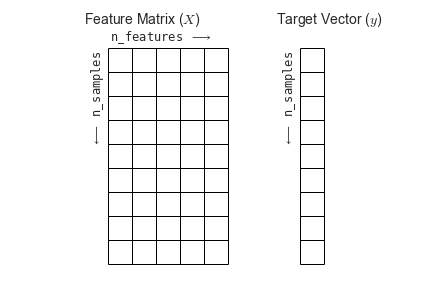

To separate our features from the outcome label, we can use "%in%" to remove the "Outcome" column from the dataframe, and reassign the result to X_df. For the outcome label, we can simply assign the "Outcome" column to a new vector.

In [22]:
X_df <- diabetes_df[, !names(diabetes_df) %in% "Outcome"]
y_df <- diabetes_df$Outcome

Using the dim() and length() methods, we can varify that X_df and y_df are what we expect. The data for all 768 patients has been separated in the 8 feature columns and 1 label column.

In [23]:
X_shape <- dim(X_df)
X_shape

y_shape <- length(y_df)
y_shape

[1] 768   8

[1] 768

We can inspect our feature matrix and vector of labels using head().



In [24]:
head(X_df)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,6,148,72,35,125,33.6,0.627,50
2,1,85,66,29,125,26.6,0.351,31
3,8,183,64,29,125,23.3,0.672,32
4,1,89,66,23,94,28.1,0.167,21
5,0,137,40,35,168,43.1,2.288,33
6,5,116,74,29,125,25.6,0.201,30


In [25]:
head(y_df)

[1] 1 0 1 0 1 0

To begin, let's build models on a subset of `X` (say 2 features). This will make visualization easier. We can subset the feature data frame by a list of columns, in this case, "Glucose and "Age".

In [26]:
X_subset_df <- X_df[, c("Glucose", "Age")]

Here we build a simple function to visualize a 2D dataset and color the points by the outcome label. The function takes in 3 variables; the features (X_df), the labels (y), and the plot title (title) which is set to "Data in 2D" by default. The function returns the figure.

In [27]:
# Function to visualize 2D data
visualize_2d <- function(X_df, y, title = "Data in 2D") {
  # Combine X_df and y into a data frame for ggplot2
  plot_data <- cbind(X_df, Outcome = as.factor(y))

  # Create the plot
  fig <- ggplot(plot_data, aes(x = Glucose, y = Age, color = Outcome)) +
    geom_point(size = 3) +
    labs(title = title, x = "x1", y = "x2") +
    theme_minimal(base_size = 14) +
    theme(legend.position = "right")

  # Display the plot
  print(fig)

  # Return the plot object for further use
  return(fig)
}



By setting the feature and label dataframes to our subset of data, we can visualize the relationship between Glucose on the x-axis with age on the y-axis.

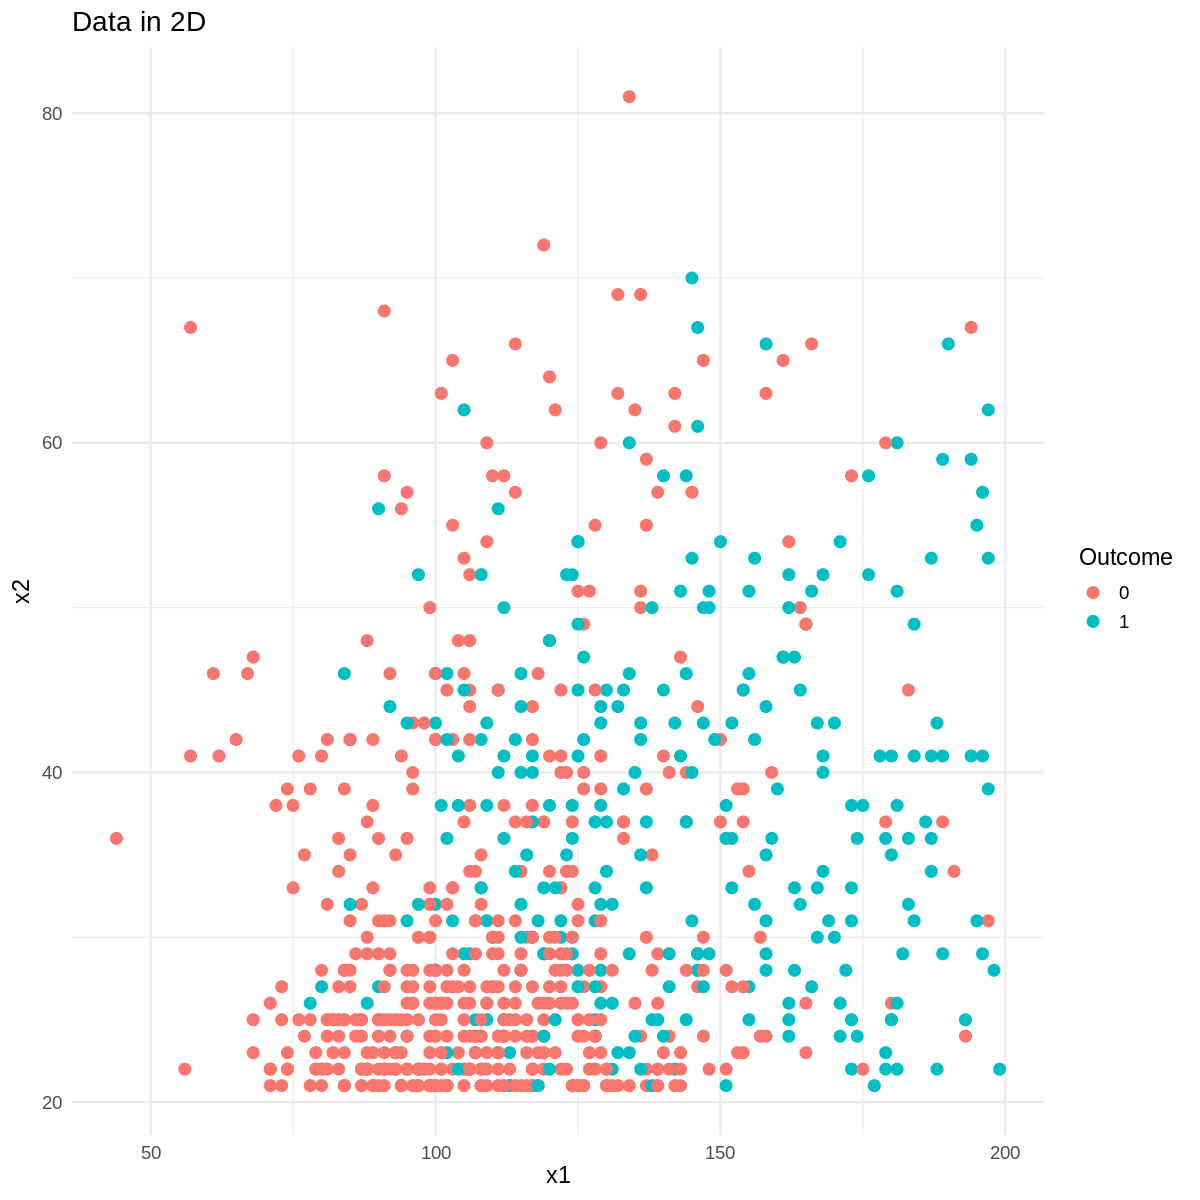

In [28]:
fig <- visualize_2d(X_subset_df, y_df)


There seems to be a relationship between these 2 vairables and diabetes, where it seems more likely that increasing age and glucose levels are associated with diabetes

## Part 2: Logistic Regression

Let's fit a **Logistic Regression** model on this 2d data. Logistic Regression is a basic **classification model** that uses a logistic function to model a binary dependent variable. R has a built in function to generate fit generalized linear models called glm()/ https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/glm

We define the data frame and which columns we want to use for the dependent and independent variables. In this case, we are using a binomial distribution to model the dependence of the Outcome on the Glucose and Age columns of the "diabetes_df" dataframe.

In [29]:
lr_model <- glm(Outcome ~ Glucose + Age, data = diabetes_df, family = binomial)
summary(lr_model)


Call:
glm(formula = Outcome ~ Glucose + Age, family = binomial, data = diabetes_df)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.246837   0.477889 -13.072  < 2e-16 ***
Glucose      0.038362   0.003414  11.238  < 2e-16 ***
Age          0.024194   0.007453   3.246  0.00117 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 993.48  on 767  degrees of freedom
Residual deviance: 783.05  on 765  degrees of freedom
AIC: 789.05

Number of Fisher Scoring iterations: 4


Here, we define a funtion to visualize the decision boundary of the 2-d model by plotting the decision boundary on the same plot as our datapoints.

In [30]:
plot_decision_boundary <- function(model, data) {
  # Create a grid of values for prediction
  xlim <- range(data$Glucose)
  ylim <- range(data$Age)

  # Generate a sequence of values for Glucose and Age
  x_vals <- seq(xlim[1], xlim[2], length.out = 100)
  y_vals <- seq(ylim[1], ylim[2], length.out = 100)

  # Create a grid of points
  grid <- expand.grid(Glucose = x_vals, Age = y_vals)

  # Predict probabilities using the model
  grid$prob <- predict(model, newdata = grid, type = "response")

  # Add the Outcome variable to the original data
  data$Outcome <- as.factor(data$Outcome)  # Ensure Outcome is a factor

  # Create the base plot
  fig <- ggplot(data, aes(x = Glucose, y = Age, color = Outcome)) +
    geom_point(size = 2, alpha = 0.7) +
    geom_contour(data = grid, aes(z = prob), breaks = 0.5, color = "black", linewidth = 1) +  # Use linewidth instead of size
    labs(title = "Decision Boundary", x = "Glucose", y = "Age") +
    theme_minimal(base_size = 14)

  # Return the plot object
  return(fig)
}


Now we can plot the dicision boundary of our 2D regression model.

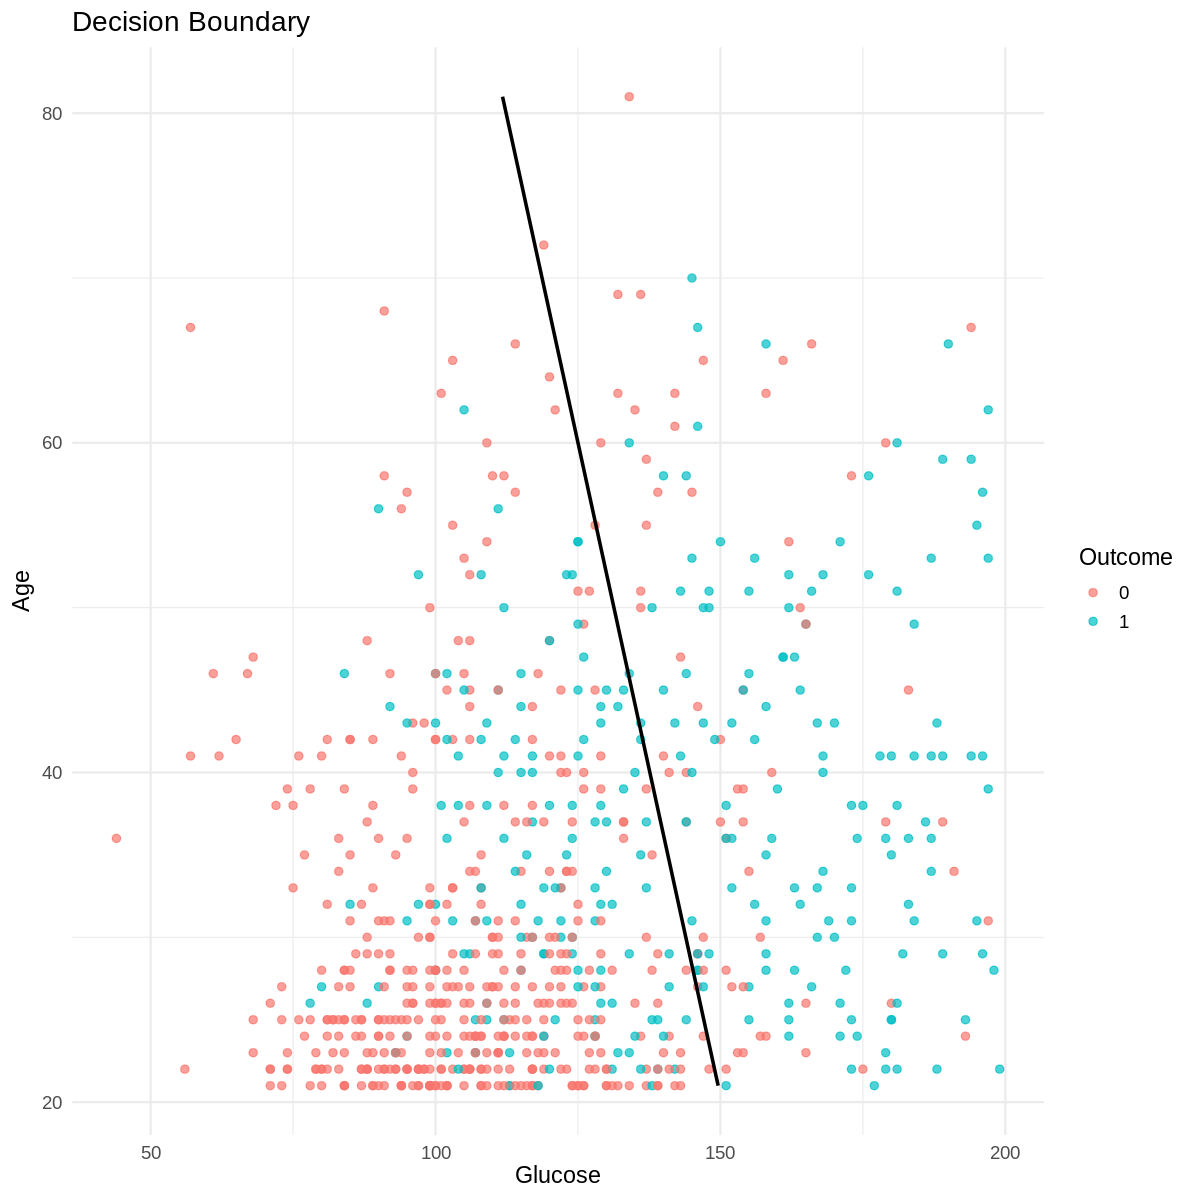

In [31]:
fig <- plot_decision_boundary(lr_model, diabetes_df)
print(fig)

We can see that the model does an OK job separating out those with diabetes from those without. However there are a number of cases that fall on the "wrong" side of the line, which would result in a false positive or false negative prediction.

Question: what is this decision boundry in Logistic Regression?

Answer: The model decision function for 2 variable is: y = w1\*x1 + w2\*x2 + c, which defines a line. The coeficients w1 and w2, and intercept can be extracted using methods using the coef() function on the model fit with glm().

In [32]:
print(coef(lr_model))

(Intercept)     Glucose         Age 
-6.24683731  0.03836154  0.02419374 


## Part 3: Train and Test Sets: Splitting Data

A machine learning model aims to make good predictions on new, previously unseen data. But if you are building a model from your data set, how would you get the previously unseen data? Well, one way is to divide your data set into two subsets:

* **training set** — a subset to train a model.
* **test set** — a subset to test the model.

Good performance on the test set is a useful indicator of good performance on the new data in general, assuming that:

* The test set is large enough.
* You don't cheat by using the same test set over and over.




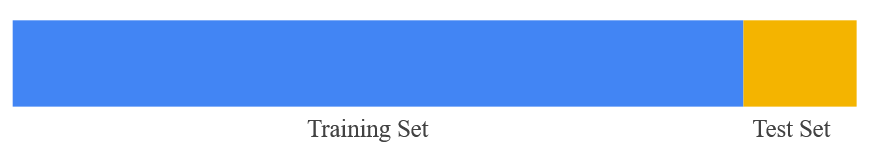

**Never train on test data**. If you are seeing surprisingly good results on your evaluation metrics, it might be a sign that you are accidentally training on the test set. For example, high accuracy might indicate that test data has leaked into the training set

The size of the test set is defined as a percentage of this entire set by the "size" variable of the sample() function. In this case, we split 20% of our dataset into the test set, and will train on the remaining 80% of the data. For reproducibility, we set the seed for the sample() funtion using set.seed().

In [33]:
set.seed(2)

# Create a random sample of row indices for training
train_indices <- sample(1:nrow(diabetes_df), size = 0.8 * nrow(diabetes_df))
#train_index <- createDataPartition(diabetes_df$Outcome, p = 0.8, list = FALSE)

# Split the data into training and testing sets
X_train <- diabetes_df[train_indices, -which(names(diabetes_df) == "Outcome")]
y_train <- diabetes_df[train_indices, "Outcome"]
X_test <- diabetes_df[-train_indices, -which(names(diabetes_df) == "Outcome")]
y_test <- diabetes_df[-train_indices, "Outcome"]


And we can verify the size of our training and test sets using the dim and length methods.

In [34]:
dim(X_train)
dim(X_test)
length(y_train)
length(y_test)

[1] 614   8

[1] 154   8

[1] 614

[1] 154

We can insspect the data using head().

In [35]:
head(X_train)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
710,2,93,64,32,160,38.0,0.674,23
416,3,173,84,33,474,35.7,0.258,22
392,5,166,76,29,125,45.7,0.340,27
273,3,122,78,29,125,23.0,0.254,40
349,3,99,62,19,74,21.8,0.279,26
204,2,99,70,16,44,20.4,0.235,27


In [36]:
head(y_train)

[1] 1 1 1 0 0 0

In [37]:
head(X_test)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
7,3,78,50,32,88,31.0,0.248,26
11,4,110,92,29,125,37.6,0.191,30
15,5,166,72,19,175,25.8,0.587,51
16,7,100,72,29,125,30.0,0.484,32
18,7,107,74,29,125,29.6,0.254,31
19,1,103,30,38,83,43.3,0.183,33


In [38]:
head(y_test)

[1] 1 0 1 1 1 0

We can see how many of each class we have using the table() funtion. The training dataset has 614 diabetes patients and the test set has 154.

In [39]:
y_train_counts <- table(y_train)
y_test_counts <- table(y_test)

print("Counts in y_train:")
print(y_train_counts)

print("Counts in y_test:")
print(y_test_counts)

[1] "Counts in y_train:"
y_train
  0   1 
395 219 
[1] "Counts in y_test:"
y_test
  0   1 
105  49 


## Part 4: Train and Test Classification Models

First we train the model using glm() as before, except this time we only use the patient data in the training set.

To make predictions we use the function "predict()" and that takes the trained model as input.

Here, we will train the ML model on all 8 features and not just 2


Fit/train a model on the training dataset by first defining our training data frame, and then calling the glm() function on our training data frame.

In [40]:
#Fit the model
train_data <- data.frame(Outcome = y_train, X_train)
model <- glm(Outcome ~ ., data = train_data, family = binomial)

Every ML classifier outputs a set of numbers for each data point that represents the **probabilty** of classifying that point as a zero (no diabetes) or 1 (diabetes). This data can be found by calling the predict() method on the test set. The method returns an value for each patient in the test set, where the entry is the probability of having diabetes. As we will see below, this is useful when appying different probability thresholds to making a prediction.

In [41]:
y_pred_prob <- predict(model, newdata = X_test, type = "response")
print(y_pred_prob) #probability of 1, or having diabetes only

         7         11         15         16         18         19         24 
0.06404788 0.20071189 0.68467869 0.15998097 0.16614137 0.47756596 0.24671166 
        30         32         33         40         41         47         61 
0.24694613 0.59013293 0.04628293 0.51144030 0.84403158 0.47202419 0.05014259 
        63         64         67         72         73         74         81 
0.01194464 0.32693771 0.14729004 0.39409551 0.80048801 0.25771668 0.10264505 
        82         83         89         98        102        104        106 
0.03009956 0.09901681 0.81916296 0.01416219 0.32454748 0.02742469 0.25217573 
       112        115        117        119        120        121        123 
0.73615550 0.79457953 0.36442869 0.09487691 0.04619976 0.92920781 0.14914368 
       129        132        148        152        156        161        167 
0.20135647 0.63816620 0.24545110 0.11235711 0.90516878 0.42249033 0.49472309 
       172        179        184        185        187        19

We can use the predict() method on the trained model to generate predictions on the test set. The output is actually a probablity, so we also apply a threshold that assigns a value of 1 if the probabily is greater that 0.5, otherwise it assigns a 0.

In [42]:
#Generate Predictions

y_pred_prob <- predict(model, newdata = X_test, type = "response")
y_pred <- ifelse(y_pred_prob > 0.5, 1, 0)
print(y_pred)

  7  11  15  16  18  19  24  30  32  33  40  41  47  61  63  64  67  72  73  74 
  0   0   1   0   0   0   0   0   1   0   1   1   0   0   0   0   0   0   1   0 
 81  82  83  89  98 102 104 106 112 115 117 119 120 121 123 129 132 148 152 156 
  0   0   0   1   0   0   0   0   1   1   0   0   0   1   0   0   1   0   0   1 
161 167 172 179 184 185 187 194 195 201 207 209 211 219 223 224 237 247 249 253 
  0   0   1   1   0   0   1   1   0   0   1   0   0   0   0   1   1   0   0   0 
256 274 277 278 282 294 308 315 316 323 327 332 335 339 340 341 345 352 354 363 
  0   0   0   0   1   1   0   0   0   0   0   0   0   1   1   0   0   0   0   0 
368 370 398 403 409 422 423 424 430 438 441 448 453 455 457 458 467 470 471 476 
  0   0   0   0   1   0   0   0   0   0   1   0   0   0   0   0   0   1   1   0 
483 487 490 493 495 498 509 511 514 529 531 535 538 539 545 551 554 558 571 576 
  0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
577 580 591 597 601 634 657 

We can plot the probability of having diabeties as a histogram to visualize the prediction results.

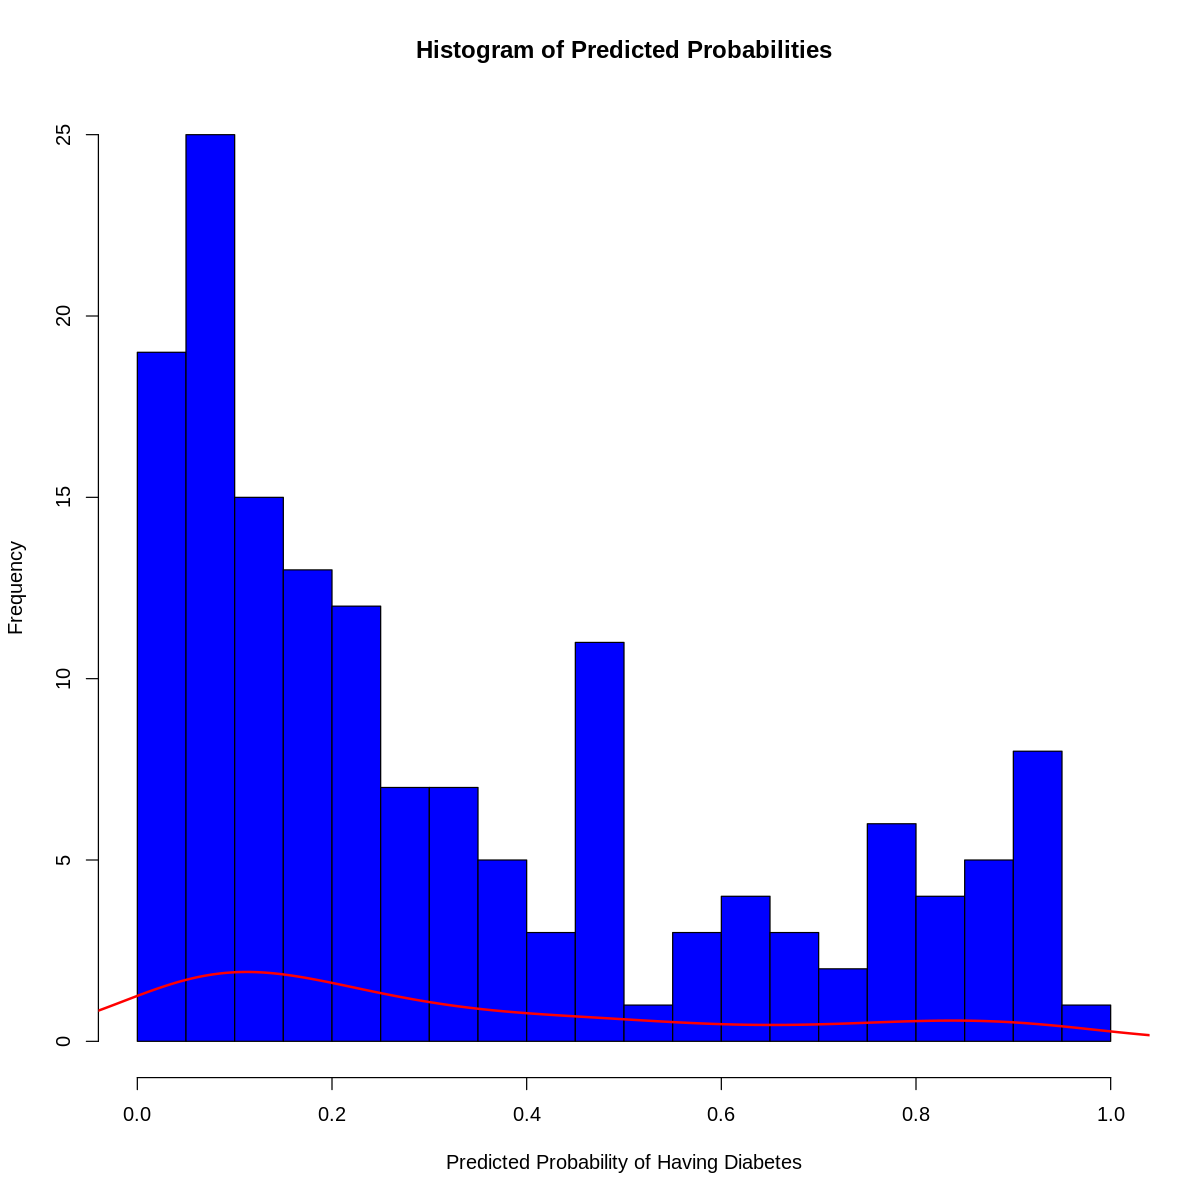

In [43]:
hist(y_pred_prob,
     breaks = 30,
     main = "Histogram of Predicted Probabilities",
     xlab = "Predicted Probability of Having Diabetes",
     col = "blue",
     border = "black")

lines(density(y_pred_prob), col = "red", lwd = 2)

## Part 5: Evaluation of the Classification Model

After training the classification model on the training set and generating predictions on the test set, we would like to quality of the predictions i.e. the performance of the trained classification model on new test set. This is done using standard classification evaluation metrics such as **accuracy, precision and recall**. These require the list of predictions of your model and the actual labels/outcomes (ground truths)

### Confusion Matrix

We calculate the confusion matrix to evaluate performance of our model. We then review and caclulate the different metrics.

A confusion matrix is a cross-tabulation that shows the correct class (or label) for each datapoint that was tested, along with the predicted class. You can use this 2-way table to determine if your model is making Type 1 (False Positve) or Type 2 (False Negative) errors.

In [44]:
cm <- confusionMatrix(as.factor(y_pred), as.factor(y_test), positive = "1")

In [45]:
cm

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 96 21
         1  9 28
                                          
               Accuracy : 0.8052          
                 95% CI : (0.7337, 0.8645)
    No Information Rate : 0.6818          
    P-Value [Acc > NIR] : 0.0004369       
                                          
                  Kappa : 0.5197          
                                          
 Mcnemar's Test P-Value : 0.0446097       
                                          
            Sensitivity : 0.5714          
            Specificity : 0.9143          
         Pos Pred Value : 0.7568          
         Neg Pred Value : 0.8205          
             Prevalence : 0.3182          
         Detection Rate : 0.1818          
   Detection Prevalence : 0.2403          
      Balanced Accuracy : 0.7429          
                                          
       'Positive' Class : 1               
                                    

A confusion matriz is a way to visualize how many predictions were correct. That is, the predicted diagnosis on the test set matched the prediction. We can see that 96 patients were correctly predicted to not have diabetes and 28 patients were correctly predicted to have diabetes. However, there were 9 patients where the model predicted them to have diabetes when they did not, and 21 patients that had diabetes were incorrecly diagnosed as being health. We also need the library reshape2 to access functions for manipulating our data. "reshape2" was previously installed as a dependency of the "caret" library.

Using Prediction, Reference as id variables



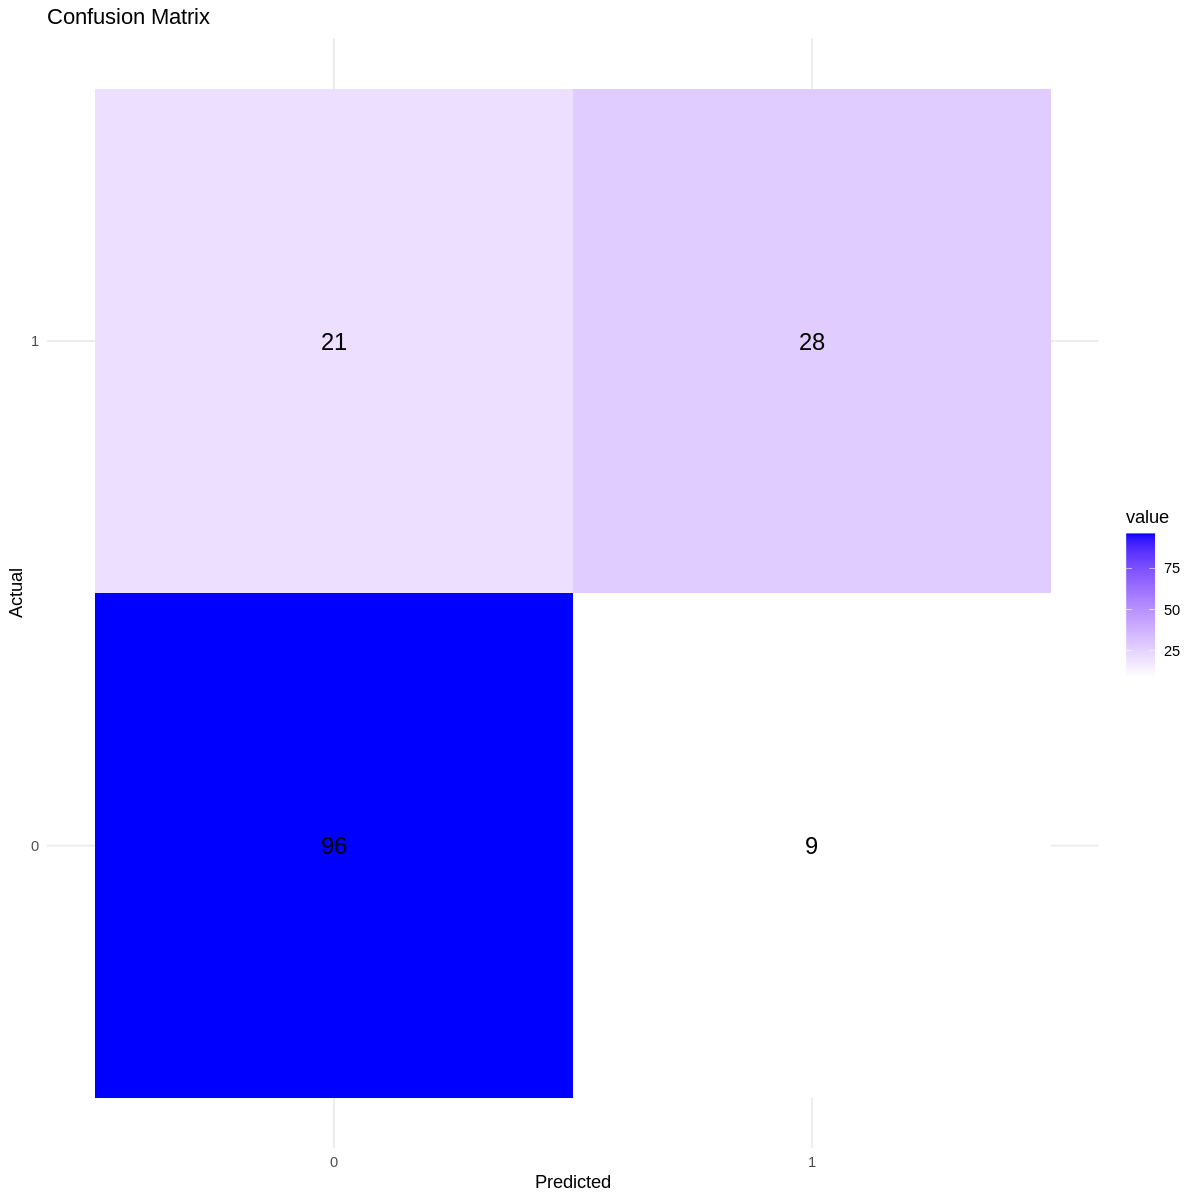

In [46]:
library(reshape2)
cm_table <- as.data.frame(cm$table)


# Convert the table for ggplot2
cm_melted <- melt(cm_table)

# Plot the confusion matrix with ggplot2
ggplot(data = cm_melted, aes(x = Prediction, y = Reference, fill = value)) +
  geom_tile() +
  geom_text(aes(label = value), color = "black", size = 5) +
  scale_fill_gradient(low = "white", high = "blue") +
  labs(title = "Confusion Matrix", x = "Predicted", y = "Actual") +
  theme_minimal()

### Types of Errors

When making a prediction for a two-class classification problem, the following types of prediction vs actual can be made by a classifier:

* **False Positive (FP):** predict an event when there was no event.
* **False Negative (FN):** predict no event when in fact there was an event.
* **True Positive (TP):** predict an event when there was an event.
* **True Negative (TN):** predict no event when in fact there was no event.

Remember

* Type I Error  = False Positive  (Predicted 1, Actual 0)
* Type II Error = False Negative: (Predicted 0, Actual 1)

In [47]:
cm_table <- cm$table
#We use the confusion matrix function to extract the different types of errors
tn <- cm_table[1, 1]  # True negatives
fp <- cm_table[2, 1]  # False positives
fn <- cm_table[1, 2]  # False negatives
tp <- cm_table[2, 2]  # True positives

# Print TN, FP, FN, TP
tn
fp
fn
tp

[1] 96

[1] 9

[1] 21

[1] 28

### Compute different evaluation metrics

We can quantify error in different ways to get a sense of how well the model is performing. In this section we will use scoring functions and the types of errors derived from the confusion matrix functions to evaluate our classification model.

In [48]:
# Accuracy
accuracy <- (tp + tn) / (tp + tn + fp + fn)
cat('Accuracy: ', sprintf('%.3f', accuracy), "\n")

# Recall/Sensitivity/True Positive Rate (TPR)
recall <- tp / (tp + fn)
cat('Recall: ', sprintf('%.3f', recall), "\n")

# Precision
precision <- tp / (tp + fp)
cat('Precision: ', sprintf('%.3f', precision), "\n")

# Specificity/True Negative Rate (TNR)
spec <- tn / (tn + fp)
cat('Specificity: ', sprintf('%.3f', spec), "\n")

# F1 Score
f1 <- 2 * (precision * recall) / (precision + recall)
cat('F1 Score: ', sprintf('%.3f', f1), "\n")

Accuracy:  0.805 
Recall:  0.571 
Precision:  0.757 
Specificity:  0.914 
F1 Score:  0.651 


These functions are also a part of the "Metrics" package.

In [49]:
install.packages("Metrics")
library(Metrics)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘Metrics’


The following object is masked _by_ ‘.GlobalEnv’:

    auc




In [50]:
specificity

function (data, ...) 
{
    UseMethod("specificity")
}
<bytecode: 0x5a0cb3f42c60>

In [51]:
# Accuracy
accuracy <- sum(y_pred == y_test) / length(y_test)
cat('Accuracy: ', sprintf('%.3f', accuracy), "\n")

# Recall
recall <- recall((y_test), (y_pred))
cat('Recall: ', sprintf('%.3f', recall), "\n")

# Precision
precision <- posPredValue(as.factor(y_pred), as.factor(y_test), positive="1")
cat('Precision: ', sprintf('%.3f', precision), "\n")

# F1 Score
f1 <- 2 * (precision * recall) / (precision + recall)
cat('F1 Score: ', sprintf('%.3f', f1), "\n")

Accuracy:  0.805 
Recall:  0.571 
Precision:  0.757 
F1 Score:  0.651 


Helper function that take actual labels and predictions as input and prints the classification metrics. Same as before just encapsulated in a function so that we can call it with different inputs

In [52]:
#Function that calculates and print metrics
show_metrics <- function(y_test, y_pred) {
  cat('====================\n')

  # Accuracy
  accuracy <- sum(y_pred == y_test) / length(y_test)
cat('Accuracy: ', sprintf('%.3f', accuracy), "\n")

# Recall
recall <- recall((y_test), (y_pred))
cat('Recall: ', sprintf('%.3f', recall), "\n")

# Precision
precision <- posPredValue(as.factor(y_pred), as.factor(y_test), positive="1")
cat('Precision: ', sprintf('%.3f', precision), "\n")

# F1 Score
f1 <- 2 * (precision * recall) / (precision + recall)
cat('F1 Score: ', sprintf('%.3f', f1), "\n")

  cat('====================\n')
}


In [53]:
show_metrics(y_test, y_pred)

Accuracy:  0.805 
Recall:  0.571 
Precision:  0.757 
F1 Score:  0.651 


**Metrics with different threshold**

We can use the prediction probablility to alter the threshold where a predicion is made. Initially, we can use a threshold of 50% (threshold=0.5) to predict a diabetes diagnosis when the prediction probability is greater than 50%.

In [54]:
#Function that returns predictions at a specific threshold
get_predictions <- function(y_pred_prob, threshold = 0.5) {
  if (is.vector(y_pred_prob)) {
    # If it's a vector, return predictions based on threshold for a binary classification
    predictions <- ifelse(y_pred_prob <= threshold, 0, 1)
  } else {
    # If it's a matrix, assume second column contains probabilities for class 1
    predictions <- ifelse(y_pred_prob[, 2] <= threshold, 0, 1)
  }
  return(predictions)
}

**Increase the threshold**

We can be more strict, and apply a higher prediction threshold. When we increase the threshold to 70% there is a change in the model performance. The number of false positives decreases, but false negatives increase. As a result, precision increases, while recall decreases:

In [55]:
y_pred1 <- get_predictions(y_pred_prob, 0.7)
show_metrics(y_test, y_pred1)

Accuracy:  0.773 
Recall:  0.408 
Precision:  0.769 
F1 Score:  0.533 


**Decrease the threshold**
Similarly, a decrease in the threshold also changes the performance. False positives increase, and false negatives decrease. As a result, this time, precision decreases and recall increases:


In [56]:
y_pred2 = get_predictions(y_pred_prob, 0.3)
show_metrics(y_test, y_pred2)

Accuracy:  0.714 
Recall:  0.694 
Precision:  0.540 
F1 Score:  0.607 


#### Threshold independent Metric: **AUC-ROC**

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

* True Positive Rate
* False Positive Rate


An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

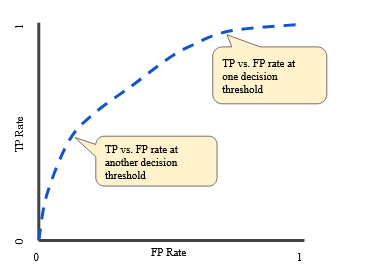

The library "pROC" has several functions that let us quantify the ROC. First we need to install and load the library.

And now we can calculate the AUC-ROC.

In [57]:
#AUROC = Area Under the Receiver Operating Characteristic curve

if (is.vector(y_pred_prob)) {
  prob_class_1 <- y_pred_prob
} else {
  prob_class_1 <- y_pred_prob[, 2]  # Assuming class 1 probabilities are in the second column
}

# Calculate AUC-ROC
roc_obj <- roc(y_test, prob_class_1)
roc_auc <- roc_obj$auc

# Print the AUC-ROC value
cat('AUCROC: ', sprintf('%.3f', roc_auc), "\n")

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUCROC:  0.814 


Generate FPR and TPR at different thresholds using the results of the roc() function.

In [58]:
fpr <- 1 - roc_obj$specificities  # False Positive Rate
tpr <- roc_obj$sensitivities        # True Positive Rate
thresholds <- roc_obj$thresholds    # Thresholds

In [59]:
# Check shape of y_test
y_test_shape <- length(y_test)  # For a vector
cat("Shape of y_test:", y_test_shape, "\n")

# Check shape of thresholds
thresholds_shape <- length(thresholds)  # For a vector
cat("Shape of thresholds:", thresholds_shape, "\n")

Shape of y_test: 154 
Shape of thresholds: 155 


DataFrame showing three columns: FPR, TPR and Threshold. This represents different values of FPR and TPR at different thresholds

In [60]:
roc_df <- data.frame(FPR = fpr, TPR = tpr, Thresholds = thresholds)
roc_df

FPR,TPR,Thresholds
<dbl>,<dbl>,<dbl>
1.0000000,1.0000000,-Inf
0.9904762,1.0000000,0.01305342
0.9809524,1.0000000,0.01530063
0.9714286,1.0000000,0.02193188
0.9619048,1.0000000,0.02822972
0.9523810,1.0000000,0.02927741
0.9428571,1.0000000,0.02980981
0.9333333,1.0000000,0.03012302
0.9238095,1.0000000,0.03041179


In [61]:
#Function to plot ROC curve
plot_roc <- function(y_test, predictions, title) {
    # Calculate ROC curve
    roc_obj <- roc(y_test, predictions)

    # Calculate AUC
    roc_auc <- roc_obj$auc
    cat('AUROC: ', sprintf('%.3f', roc_auc), "\n")

    # Plot ROC curve
    plot(roc_obj, main=title, col="blue", lwd=2)
    abline(a=0, b=1, lty=2, col="red")  # Diagonal line
    legend("bottomright", legend=paste("ROC curve (area =", sprintf('%.2f', roc_auc), ")"),
           col="blue", lwd=2)
}

Let's plot the ROC curves for a perfect classifier, classifier based on random guessing and our trained model : Logistic regression. The area under the ROC curve is the AUC-ROC metric. A perfect classifier has AUCROC = 1 and random guessing will have a AUCROC around 0.5.
Our trained Logistic Regression classifier has a AUCROC of 0.8

In [62]:
# pROC: Tools Receiver operating characteristic (ROC curves) with
# (partial) area under the curve, confidence intervals and comparison.
# Copyright (C) 2010-2014 Xavier Robin, Alexandre Hainard, Natacha Turck,
# Natalia Tiberti, FrÃ©dÃ©rique Lisacek, Jean-Charles Sanchez
# and Markus MÃ¼ller
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

plot.roc <- function(x, ...) {
  UseMethod("plot.roc")
}

plot.roc.formula <- function(x, data, subset, na.action, ...) {
  data.missing <- missing(data)
  call <- match.call()
  names(call)[2] <- "formula" # forced to be x by definition of plot
  roc.data <- roc_utils_extract_formula(
    formula = x, data, subset, na.action, ...,
    data.missing = data.missing,
    call = call
  )
  if (length(roc.data$predictor.name) > 1) {
    stop("Only one predictor supported in 'plot.roc'.")
  }
  response <- roc.data$response
  predictor <- roc.data$predictors[, 1]

  roc <- roc(response, predictor, plot = TRUE, ...)
  roc$call <- match.call()
  invisible(roc)
}

plot.roc.default <- function(x, predictor, ...) {
  roc <- roc(x, predictor, plot = TRUE, ...)
  roc$call <- match.call()
  invisible(roc)
}

plot.roc.smooth.roc <- plot.smooth.roc <- function(x, ...) {
  invisible(plot.roc.roc(x, ...)) # force usage of plot.roc.roc: only print.thres not working
}

plot.roc.roc <- function(x,
                         add = FALSE,
                         reuse.auc = TRUE,
                         axes = TRUE,
                         legacy.axes = FALSE,
                         xlim = if (x$percent) {
                           c(100, 0)
                         } else {
                           c(1, 0)
                         },
                         ylim = if (x$percent) {
                           c(0, 100)
                         } else {
                           c(0, 1)
                         },
                         xlab = ifelse(x$percent, ifelse(legacy.axes, "100 - Specificity (%)", "Specificity (%)"), ifelse(legacy.axes, "1 - Specificity", "Specificity")),
                         ylab = ifelse(x$percent, "Sensitivity (%)", "Sensitivity"),
                         asp = 1,
                         mar = c(4, 4, 2, 2) + .1,
                         mgp = c(2.5, 1, 0),
                         # col, lty and lwd for the ROC line only
                         col = par("col"),
                         lty = par("lty"),
                         lwd = 2,
                         type = "l",
                         # Identity line
                         identity = !add,
                         identity.col = "darkgrey",
                         identity.lty = 1,
                         identity.lwd = 1,
                         # Print the thresholds on the plot
                         print.thres = FALSE,
                         print.thres.pch = 20,
                         print.thres.adj = c(-.05, 1.25),
                         print.thres.col = "black",
                         print.thres.pattern = ifelse(x$percent, "%.1f (%.1f%%, %.1f%%)", "%.3f (%.3f, %.3f)"),
                         print.thres.cex = par("cex"),
                         print.thres.pattern.cex = print.thres.cex,
                         print.thres.best.method = NULL,
                         print.thres.best.weights = c(1, 0.5),
                         # Print the AUC on the plot
                         print.auc = FALSE,
                         print.auc.pattern = NULL,
                         print.auc.x = ifelse(x$percent, 50, .5),
                         print.auc.y = ifelse(x$percent, 50, .5),
                         print.auc.adj = c(0, 1),
                         print.auc.col = col,
                         print.auc.cex = par("cex"),
                         # Grid
                         grid = FALSE,
                         grid.v = {
                           if (is.logical(grid) && grid[1] == TRUE) {
                             seq(0, 1, 0.1) * ifelse(x$percent, 100, 1)
                           } else if (is.numeric(grid)) {
                             seq(0, ifelse(x$percent, 100, 1), grid[1])
                           } else {
                             NULL
                           }
                         },
                         grid.h = {
                           if (length(grid) == 1) {
                             grid.v
                           } else if (is.logical(grid) && grid[2] == TRUE) {
                             seq(0, 1, 0.1) * ifelse(x$percent, 100, 1)
                           } else if (is.numeric(grid)) {
                             seq(0, ifelse(x$percent, 100, 1), grid[2])
                           } else {
                             NULL
                           }
                         },
                         # for grid.lty, grid.lwd and grid.col, a length 2 value specifies both values for vertical (1) and horizontal (2) grid
                         grid.lty = 3,
                         grid.lwd = 1,
                         grid.col = "#DDDDDD",
                         # Polygon for the auc
                         auc.polygon = FALSE,
                         auc.polygon.col = "gainsboro", # Other arguments can be passed to polygon() using "..." (for these two we cannot)
                         auc.polygon.lty = par("lty"),
                         auc.polygon.density = NULL,
                         auc.polygon.angle = 45,
                         auc.polygon.border = NULL,
                         # Should we show the maximum possible area as another polygon?
                         max.auc.polygon = FALSE,
                         max.auc.polygon.col = "#EEEEEE", # Other arguments can be passed to polygon() using "..." (for these two we cannot)
                         max.auc.polygon.lty = par("lty"),
                         max.auc.polygon.density = NULL,
                         max.auc.polygon.angle = 45,
                         max.auc.polygon.border = NULL,
                         # Confidence interval
                         ci = !is.null(x$ci),
                         ci.type = c("bars", "shape", "no"),
                         ci.col = ifelse(ci.type == "bars", par("fg"), "gainsboro"),
                         ...) {
  percent <- x$percent

  if (max.auc.polygon | auc.polygon | print.auc) { # we need the auc here
    if (is.null(x$auc) | !reuse.auc) {
      x$auc <- auc(x, ...)
    }
    partial.auc <- attr(x$auc, "partial.auc")
    partial.auc.focus <- attr(x$auc, "partial.auc.focus")
  }

  # compute a reasonable default for print.auc.pattern if required
  if (print.auc & is.null(print.auc.pattern)) {
    print.auc.pattern <- ifelse(identical(partial.auc, FALSE), "AUC: ", "Partial AUC: ")
    print.auc.pattern <- paste(print.auc.pattern, ifelse(percent, "%.1f%%", "%.3f"), sep = "")
    if (ci && methods::is(x$ci, "ci.auc")) {
      print.auc.pattern <- paste(print.auc.pattern, " (", ifelse(percent, "%.1f%%", "%.3f"), "\u2013", ifelse(percent, "%.1f%%", "%.3f"), ")", sep = "")
    }
  }

  # get and sort the sensitivities and specificities
  se <- sort(x$sensitivities, decreasing = TRUE)
  sp <- sort(x$specificities, decreasing = FALSE)
  if (!add) {
    opar <- par(mar = mar, mgp = mgp)
    on.exit(par(opar))
    # type="n" to plot background lines and polygon shapes first. We will add the line later. axes=FALSE, we'll add them later according to legacy.axis
    suppressWarnings(plot(x$specificities, x$sensitivities, xlab = xlab, ylab = ylab, type = "n", axes = FALSE, xlim = xlim, ylim = ylim, lwd = lwd, asp = asp, ...))

    # As we had axes=FALSE we need to add them again unless axes=FALSE
    if (axes) {
      box()
      # axis behave differently when at and labels are passed (no decimals on 1 and 0),
      # so handle each case separately and consistently across axes
      if (legacy.axes) {
        lab.at <- axTicks(side = 1)
        lab.labels <- format(ifelse(x$percent, 100, 1) - lab.at)
        suppressWarnings(axis(side = 1, at = lab.at, labels = lab.labels, ...))
        lab.at <- axTicks(side = 2)
        suppressWarnings(axis(side = 2, at = lab.at, labels = format(lab.at), ...))
      } else {
        suppressWarnings(axis(side = 1, ...))
        suppressWarnings(axis(side = 2, ...))
      }
    }
  }

  # Plot the grid
  # make sure grid.lty, grid.lwd and grid.col are at least of length 2
  grid.lty <- rep(grid.lty, length.out = 2)
  grid.lwd <- rep(grid.lwd, length.out = 2)
  grid.col <- rep(grid.col, length.out = 2)
  if (!is.null(grid.v)) {
    suppressWarnings(abline(v = grid.v, lty = grid.lty[1], col = grid.col[1], lwd = grid.lwd[1], ...))
  }
  if (!is.null(grid.h)) {
    suppressWarnings(abline(h = grid.h, lty = grid.lty[2], col = grid.col[2], lwd = grid.lwd[2], ...))
  }

  # Plot the polygon displaying the maximal area
  if (max.auc.polygon) {
    if (identical(partial.auc, FALSE)) {
      map.y <- c(0, 1, 1, 0) * ifelse(percent, 100, 1)
      map.x <- c(1, 1, 0, 0) * ifelse(percent, 100, 1)
    } else {
      if (partial.auc.focus == "sensitivity") {
        map.y <- c(partial.auc[2], partial.auc[2], partial.auc[1], partial.auc[1])
        map.x <- c(0, 1, 1, 0) * ifelse(percent, 100, 1)
      } else {
        map.y <- c(0, 1, 1, 0) * ifelse(percent, 100, 1)
        map.x <- c(partial.auc[2], partial.auc[2], partial.auc[1], partial.auc[1])
      }
    }
    suppressWarnings(polygon(map.x, map.y, col = max.auc.polygon.col, lty = max.auc.polygon.lty, border = max.auc.polygon.border, density = max.auc.polygon.density, angle = max.auc.polygon.angle, ...))
  }
  # Plot the ci shape
  if (ci && !methods::is(x$ci, "ci.auc")) {
    ci.type <- match.arg(ci.type)
    if (ci.type == "shape") {
      plot(x$ci, type = "shape", col = ci.col, no.roc = TRUE, ...)
    }
  }
  # Plot the polygon displaying the actual area
  if (auc.polygon) {
    if (identical(partial.auc, FALSE)) {
      suppressWarnings(polygon(c(sp, 0), c(se, 0), col = auc.polygon.col, lty = auc.polygon.lty, border = auc.polygon.border, density = auc.polygon.density, angle = auc.polygon.angle, ...))
    } else {
      if (partial.auc.focus == "sensitivity") {
        x.all <- rev(se)
        y.all <- rev(sp)
      } else {
        x.all <- sp
        y.all <- se
      }
      # find the SEs and SPs in the interval
      x.int <- x.all[x.all <= partial.auc[1] & x.all >= partial.auc[2]]
      y.int <- y.all[x.all <= partial.auc[1] & x.all >= partial.auc[2]]
      # if the upper limit is not exactly present in SPs, interpolate
      if (!(partial.auc[1] %in% x.int)) {
        x.int <- c(x.int, partial.auc[1])
        # find the limit indices
        idx.out <- match(FALSE, x.all < partial.auc[1])
        idx.in <- idx.out - 1
        # interpolate y
        proportion.start <- (partial.auc[1] - x.all[idx.out]) / (x.all[idx.in] - x.all[idx.out])
        y.start <- y.all[idx.out] - proportion.start * (y.all[idx.out] - y.all[idx.in])
        y.int <- c(y.int, y.start)
      }
      # if the lower limit is not exactly present in SPs, interpolate
      if (!(partial.auc[2] %in% x.int)) {
        x.int <- c(partial.auc[2], x.int)
        # find the limit indices
        idx.out <- length(x.all) - match(TRUE, rev(x.all) < partial.auc[2]) + 1
        idx.in <- idx.out + 1
        # interpolate y
        proportion.end <- (x.all[idx.in] - partial.auc[2]) / (x.all[idx.in] - x.all[idx.out])
        y.end <- y.all[idx.in] + proportion.end * (y.all[idx.out] - y.all[idx.in])
        y.int <- c(y.end, y.int)
      }
      # anchor to baseline
      x.int <- c(partial.auc[2], x.int, partial.auc[1])
      y.int <- c(0, y.int, 0)
      if (partial.auc.focus == "sensitivity") {
        # for SE, invert x and y again
        suppressWarnings(polygon(y.int, x.int, col = auc.polygon.col, lty = auc.polygon.lty, border = auc.polygon.border, density = auc.polygon.density, angle = auc.polygon.angle, ...))
      } else {
        suppressWarnings(polygon(x.int, y.int, col = auc.polygon.col, lty = auc.polygon.lty, border = auc.polygon.border, density = auc.polygon.density, angle = auc.polygon.angle, ...))
      }
    }
  }
  # Identity line
  if (identity) suppressWarnings(abline(ifelse(percent, 100, 1), -1, col = identity.col, lwd = identity.lwd, lty = identity.lty, ...))
  # Actually plot the ROC curve
  suppressWarnings(lines(sp, se, type = type, lwd = lwd, col = col, lty = lty, ...))
  # Plot the ci bars
  if (ci && !methods::is(x$ci, "ci.auc")) {
    if (ci.type == "bars") {
      plot(x$ci, type = "bars", col = ci.col, ...)
    }
  }
  # Print the thresholds on the curve if print.thres is TRUE
  if (isTRUE(print.thres)) {
    print.thres <- "best"
  }
  if (is.character(print.thres)) {
    print.thres <- match.arg(print.thres, c("no", "all", "local maximas", "best"))
  }
  if (methods::is(x, "smooth.roc")) {
    if (is.numeric(print.thres)) {
      stop("Numeric 'print.thres' unsupported on a smoothed ROC plot.")
    } else if (print.thres == "all" || print.thres == "local maximas") {
      stop("'all' and 'local maximas' 'print.thres' unsupported on a smoothed ROC plot.")
    } else if (print.thres == "best") {
      co <- coords(x, print.thres, best.method = print.thres.best.method, best.weights = print.thres.best.weights, transpose = FALSE)
      suppressWarnings(points(co$specificity, co$sensitivity, pch = print.thres.pch, cex = print.thres.cex, col = print.thres.col, ...))
      suppressWarnings(text(co$specificity, co$sensitivity, sprintf(print.thres.pattern, NA, co$specificity, co$sensitivity), adj = print.thres.adj, cex = print.thres.pattern.cex, col = print.thres.col, ...))
    } # else print.thres == no > do nothing
  } else if (is.numeric(print.thres) || is.character(print.thres)) {
    if (is.character(print.thres) && print.thres == "no") {} # do nothing
    else {
      co <- coords(x, print.thres, best.method = print.thres.best.method, best.weights = print.thres.best.weights, transpose = FALSE)
      suppressWarnings(points(co$specificity, co$sensitivity, pch = print.thres.pch, cex = print.thres.cex, col = print.thres.col, ...))
      suppressWarnings(text(co$specificity, co$sensitivity, sprintf(print.thres.pattern, co$threshold, co$specificity, co$sensitivity), adj = print.thres.adj, cex = print.thres.pattern.cex, col = print.thres.col, ...))
    }
  }

  # Print the AUC on the plot
  if (print.auc) {
    if (ci && methods::is(x$ci, "ci.auc")) {
      labels <- sprintf(print.auc.pattern, x$auc, x$ci[1], x$ci[3])
      suppressWarnings(text(print.auc.x, print.auc.y, labels, adj = print.auc.adj, cex = print.auc.cex, col = print.auc.col, ...))
    } else {
      labels <- sprintf(print.auc.pattern, x$auc)
    }
    suppressWarnings(text(print.auc.x, print.auc.y, labels, adj = print.auc.adj, cex = print.auc.cex, col = print.auc.col, ...))
  }

  invisible(x)
}


Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUROC:  1.000 


Setting levels: control = 0, case = 1

Setting direction: controls > cases



AUROC:  0.578 


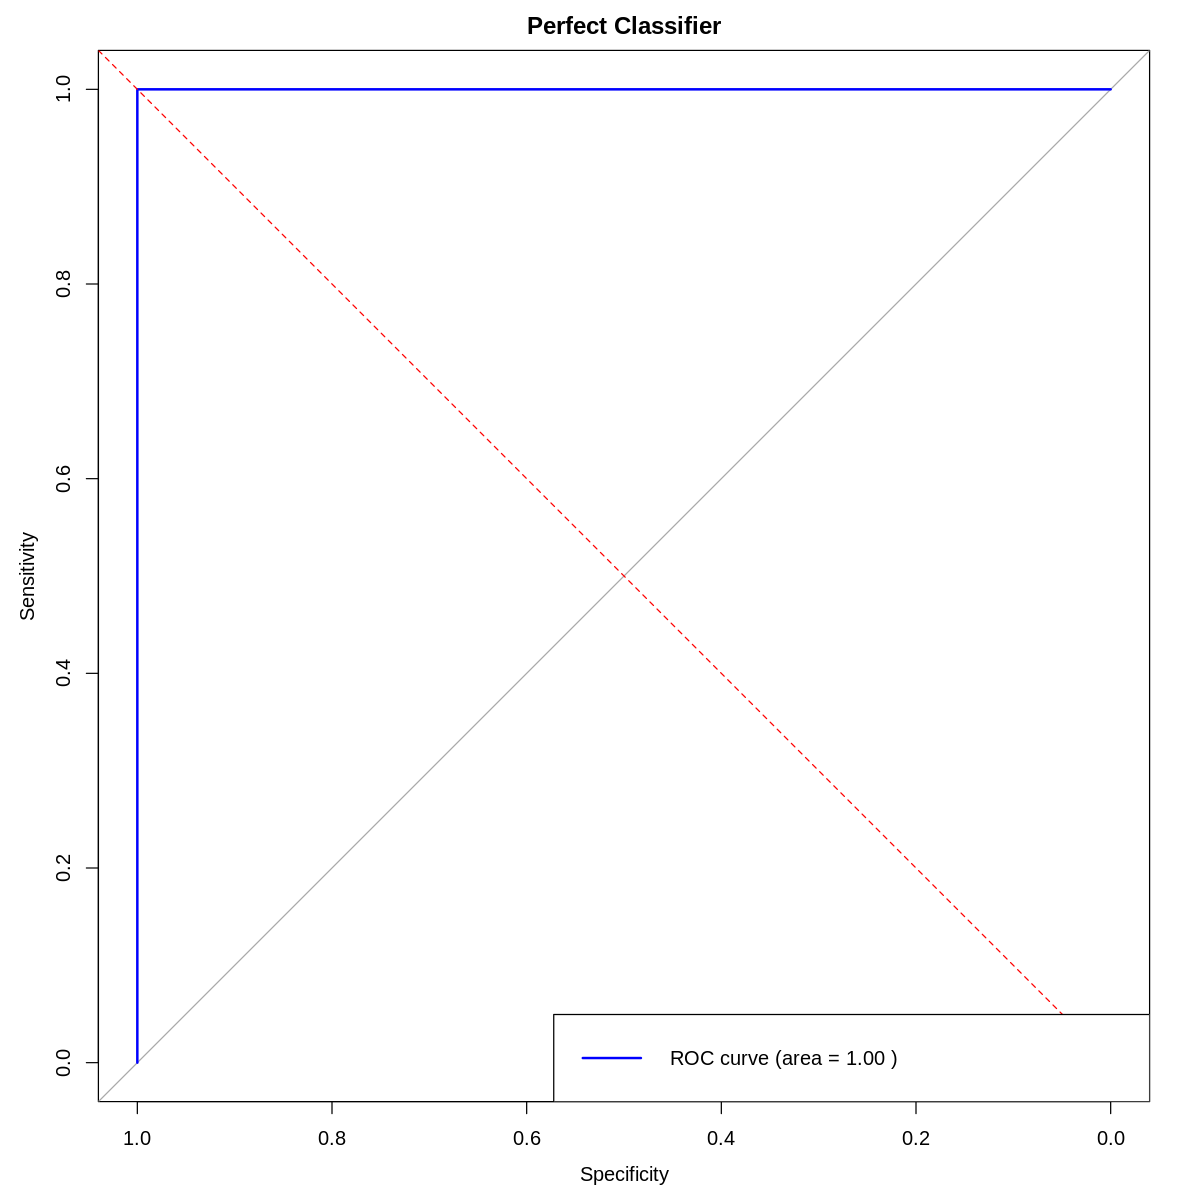

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUROC:  0.814 


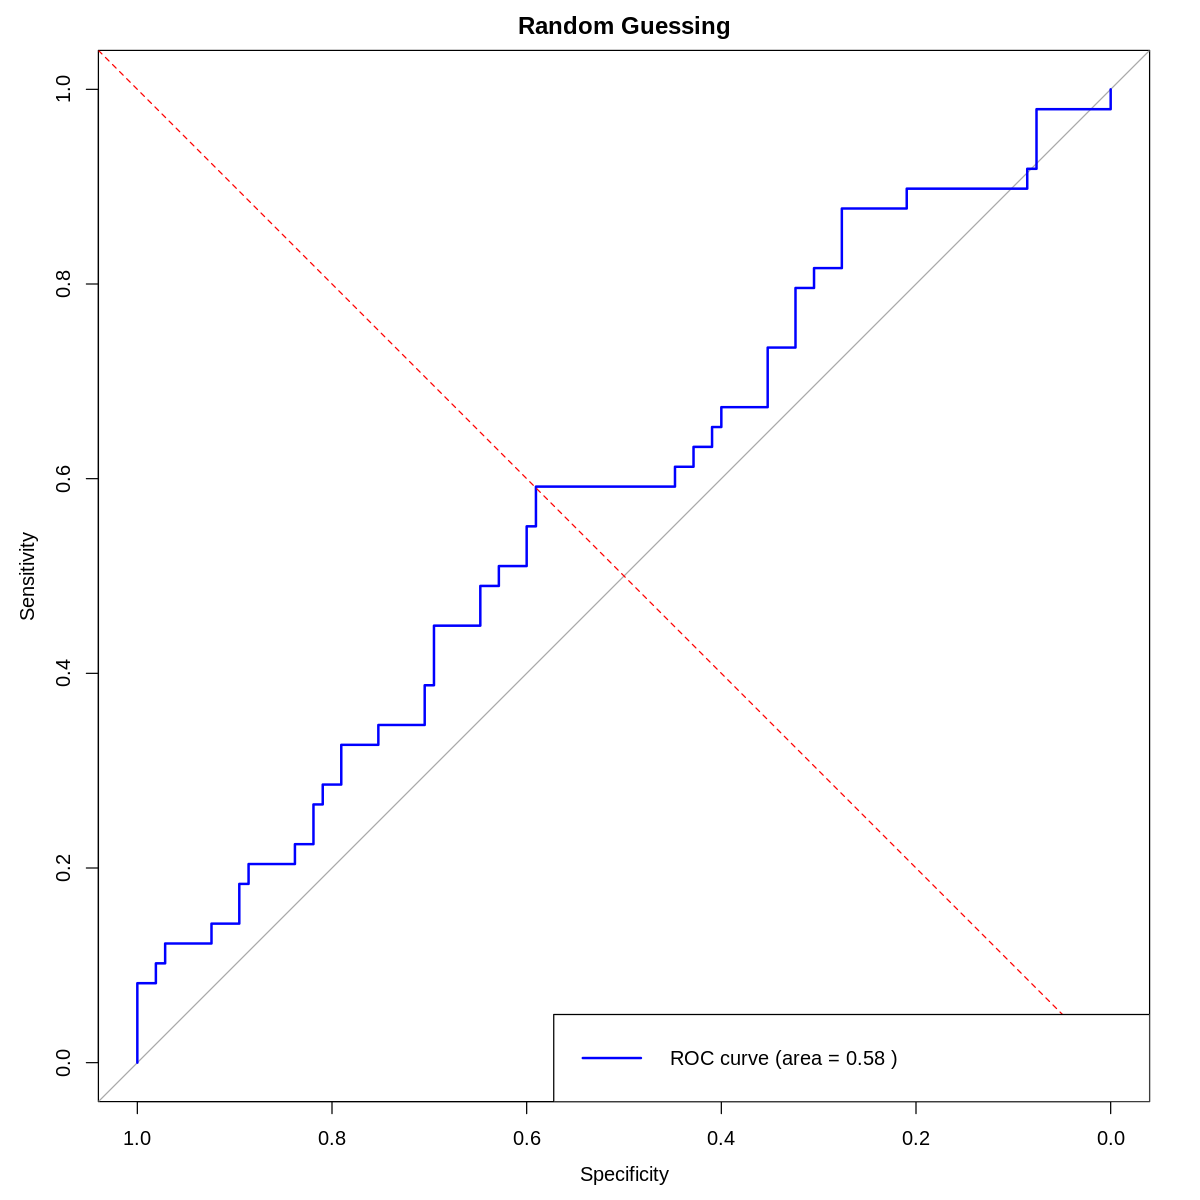

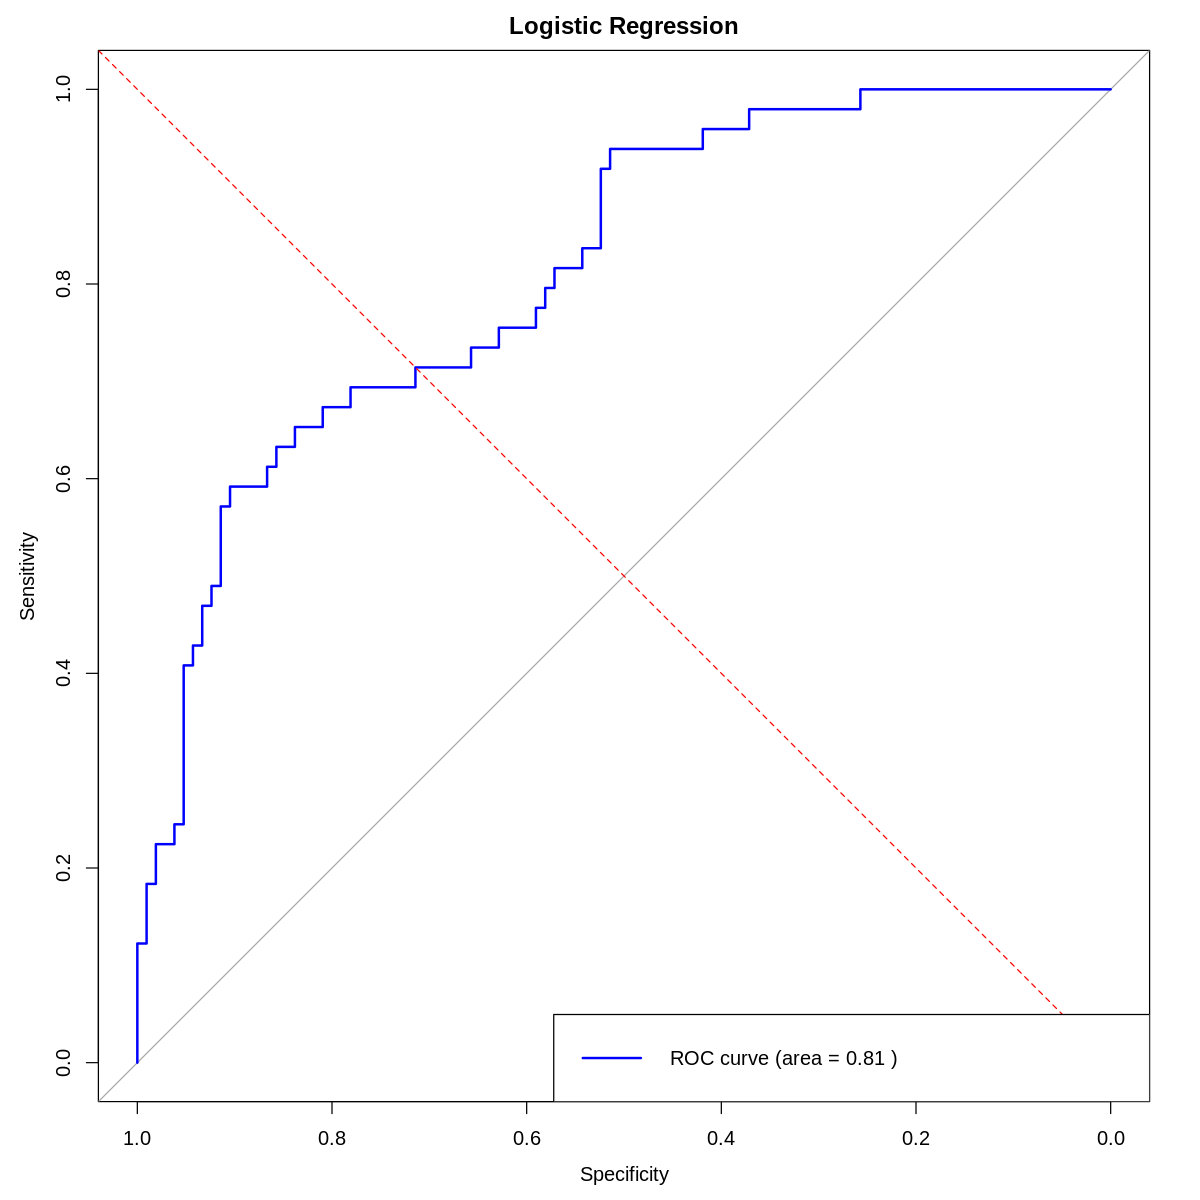

In [63]:
# Perfect classifier
perfect_predictions <- y_test  # Perfect predictions (1 for positive class and 0 for negative)
plot_roc(y_test, perfect_predictions, "Perfect Classifier")

# Random guessing
random_predictions <- runif(length(y_test))  # Random predictions between 0 and 1
plot_roc(y_test, random_predictions, "Random Guessing")

# Logistic Regression predictions
logistic_predictions <- y_pred_prob  # Assuming class 1 probabilities are in the second column
plot_roc(y_test, logistic_predictions, "Logistic Regression")

### Classification Report

You can also generate the precision, recall, and f1 scores using classification_report.

* Scores of every class correspond to the accuracy of the classifier in classifying that particular class compared to the other class.

* The support is the number of samples of the true response that are in that class.

* The last line gives a weighted average of precision, recall and f1-score where the weights are the support values.

In [64]:
confusion_matrix <- confusionMatrix(as.factor(y_pred), as.factor(y_test))

# Print the confusion matrix
print(confusion_matrix)

# Print additional metrics
cat("\nAccuracy: ", confusion_matrix$overall['Accuracy'], "\n")
cat("Precision: ", confusion_matrix$byClass['Precision'], "\n")
cat("Recall: ", confusion_matrix$byClass['Recall'], "\n")
cat("F1 Score: ", confusion_matrix$byClass['F1'], "\n")

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 96 21
         1  9 28
                                          
               Accuracy : 0.8052          
                 95% CI : (0.7337, 0.8645)
    No Information Rate : 0.6818          
    P-Value [Acc > NIR] : 0.0004369       
                                          
                  Kappa : 0.5197          
                                          
 Mcnemar's Test P-Value : 0.0446097       
                                          
            Sensitivity : 0.9143          
            Specificity : 0.5714          
         Pos Pred Value : 0.8205          
         Neg Pred Value : 0.7568          
             Prevalence : 0.6818          
         Detection Rate : 0.6234          
   Detection Prevalence : 0.7597          
      Balanced Accuracy : 0.7429          
                                          
       'Positive' Class : 0               
                                    

Another R package for generating these performacne statistics is "yardstick".

In [65]:
install.packages('yardstick')
library(yardstick)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘yardstick’


The following objects are masked _by_ ‘.GlobalEnv’:

    sensitivity, specificity


The following objects are masked from ‘package:Metrics’:

    accuracy, mae, mape, mase, precision, recall, rmse, smape




In [66]:


# Create a tibble for predictions
results <- data.frame(
    truth = as.factor(y_test),
    estimate = as.factor(y_pred)
)

# Calculate metrics
metrics <- results %>%
    metrics(truth = truth, estimate = estimate)

# Print metrics
print(metrics)

# A tibble: 2 × 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.805
2 kap      binary         0.520


### Trying Other classifiers

In [67]:
install.packages("randomForest")
library(randomForest)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine




Let's try some other classifiers. We will build a Random Forest classifier using the randomForest() function much like we did before.

https://www.rdocumentation.org/packages/randomForest/versions/4.7-1.2/topics/randomForest

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 86 19
         1 19 30
                                          
               Accuracy : 0.7532          
                 95% CI : (0.6774, 0.8191)
    No Information Rate : 0.6818          
    P-Value [Acc > NIR] : 0.03253         
                                          
                  Kappa : 0.4313          
                                          
 Mcnemar's Test P-Value : 1.00000         
                                          
            Sensitivity : 0.8190          
            Specificity : 0.6122          
         Pos Pred Value : 0.8190          
         Neg Pred Value : 0.6122          
             Prevalence : 0.6818          
         Detection Rate : 0.5584          
   Detection Prevalence : 0.6818          
      Balanced Accuracy : 0.7156          
                                          
       'Positive' Class : 0               
                                    

Using Prediction, Reference as id variables




Accuracy:  0.7532468 
Precision:  0.8190476 
Recall:  0.8190476 
F1 Score:  0.8190476 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUCROC:  0.827113702623907"


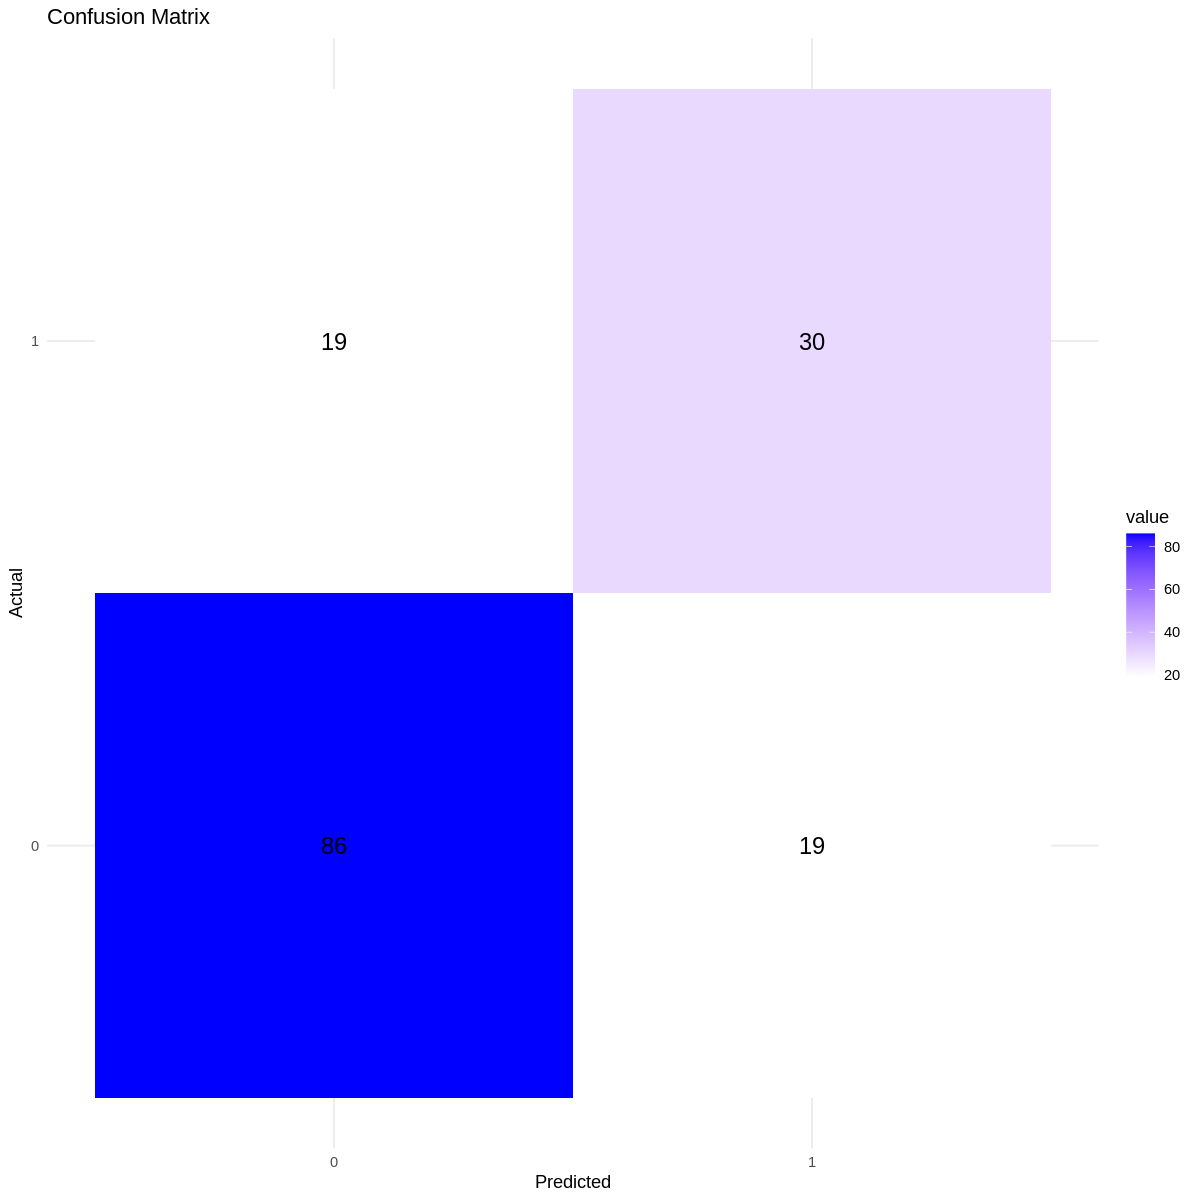

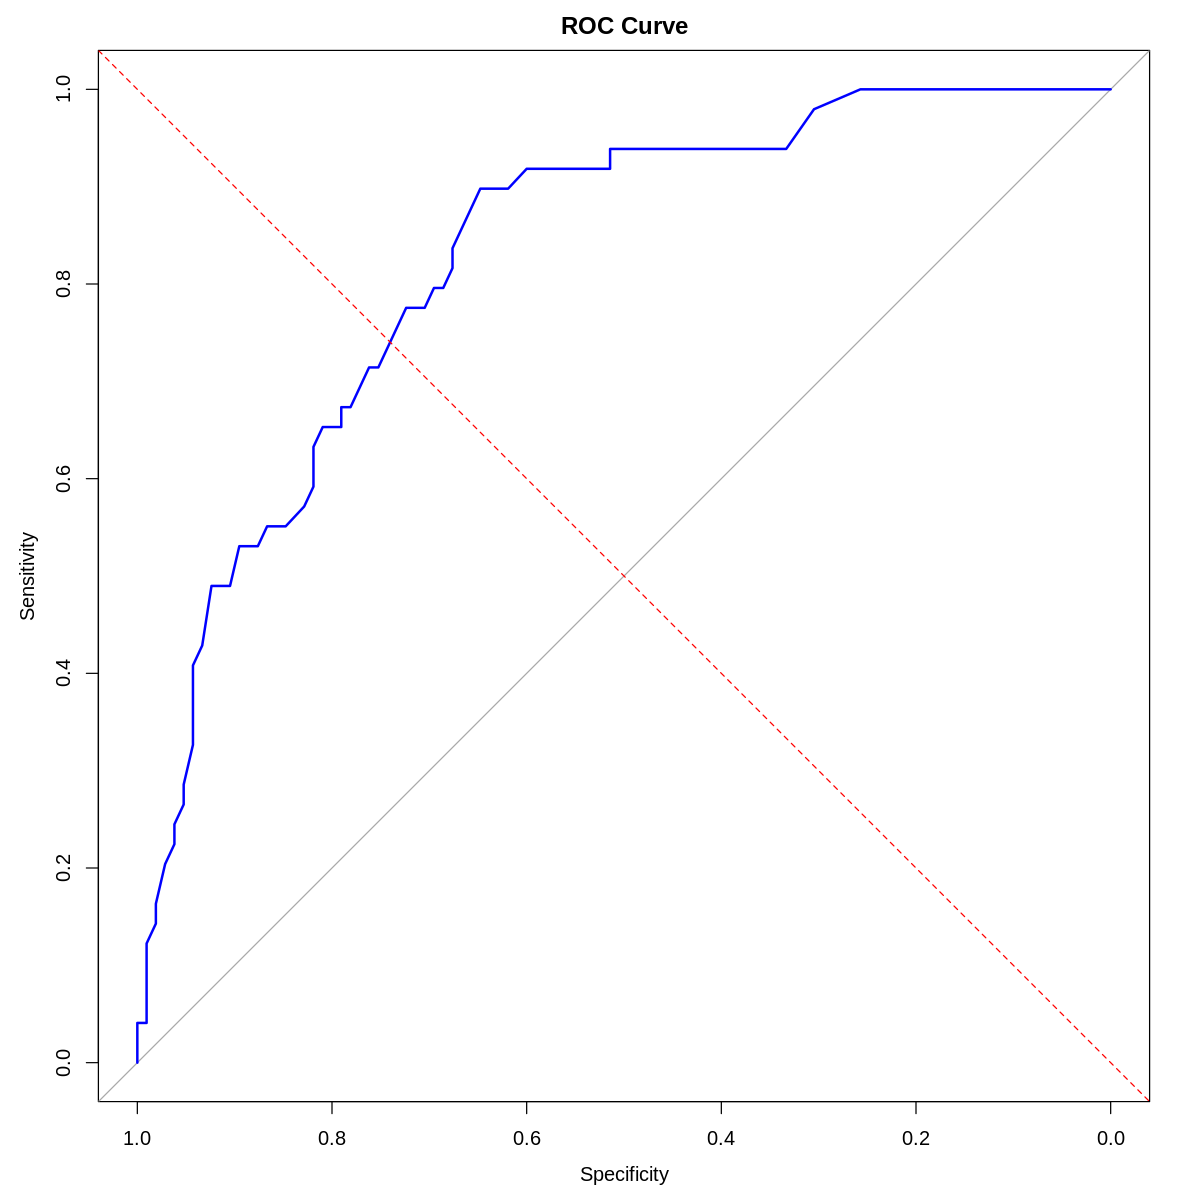

In [68]:
# Ensure the target variable is a factor

y_train <- as.factor(y_train)
y_test <- as.factor(y_test)

# Fit the Random Forest model
model <- randomForest(y_train ~ ., data = X_train, ntree = 100)

# Prediction probabilities and classes
predictions_proba <- predict(model, X_test, type = "prob")
predictions <- predict(model, X_test)

cm <- confusionMatrix(as.factor(predictions), as.factor(y_test))
print(cm)  # Display the confusion matrix

# Plot confusion matrix using caret's confusion matrix visualization
cm_table <- as.data.frame(cm$table)
cm_melted <- melt(cm_table)

# Plot the confusion matrix with ggplot2
ggplot(data = cm_melted, aes(x = Prediction, y = Reference, fill = value)) +
  geom_tile() +
  geom_text(aes(label = value), color = "black", size = 5) +
  scale_fill_gradient(low = "white", high = "blue") +
  labs(title = "Confusion Matrix", x = "Predicted", y = "Actual") +
  theme_minimal()


# Print classification metrics
cat("\nAccuracy: ", cm$overall['Accuracy'], "\n")
cat("Precision: ", cm$byClass['Precision'], "\n")
cat("Recall: ", cm$byClass['Recall'], "\n")
cat("F1 Score: ", cm$byClass['F1'], "\n")

# Compute and print AUC-ROC
roc_auc <- roc(y_test, predictions_proba[, 2])  # Assuming class 1 probabilities are in the second column
print(paste('AUCROC: ', (roc_auc)$auc))

# Plot ROC curve
plot(roc_auc, main = "ROC Curve", col = "blue", lwd = 2)
abline(a=0, b=1, lty=2, col="red")  # Diagonal line for random guessing

## Part 6: Feature Importance using Tree-Based Classifiers

We will use a tree based ensemble classifier: **XGBoost**, which is very a popular ML model to output feature importance. A benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

XGBoost Documentation: https://xgboost.readthedocs.io/en/latest/
Check this article for more information on feature importance usinfg XGBoost: https://www.rdocumentation.org/packages/xgboost/versions/1.7.5.1



In [71]:
install.packages("xgboost")
library(xgboost)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




In [72]:
# Prepare the training data
X_train_matrix <- as.matrix(X_train)  # Convert feature data to a matrix
y_train_numeric <- as.numeric(as.factor(y_train)) - 1  # Convert target to numeric

# Create DMatrix for XGBoost
dtrain <- xgb.DMatrix(data = X_train_matrix, label = y_train_numeric)

# Fit the XGBoost model
model <- xgboost(data = dtrain,
                 nrounds = 100,  # Number of boosting iterations
                 max_depth = 3,  # Maximum depth of trees
                 eta = 0.3,      # Learning rate
                 objective = "binary:logistic",  # Binary classification
                 verbose = 1)    # Verbosity of output

[1]	train-logloss:0.592999 
[2]	train-logloss:0.534422 
[3]	train-logloss:0.494133 
[4]	train-logloss:0.468829 
[5]	train-logloss:0.449840 
[6]	train-logloss:0.433751 
[7]	train-logloss:0.417024 
[8]	train-logloss:0.405804 
[9]	train-logloss:0.394202 
[10]	train-logloss:0.385534 
[11]	train-logloss:0.379299 
[12]	train-logloss:0.372022 
[13]	train-logloss:0.366129 
[14]	train-logloss:0.359340 
[15]	train-logloss:0.352384 
[16]	train-logloss:0.348462 
[17]	train-logloss:0.345815 
[18]	train-logloss:0.341729 
[19]	train-logloss:0.337103 
[20]	train-logloss:0.328706 
[21]	train-logloss:0.323746 
[22]	train-logloss:0.319991 
[23]	train-logloss:0.317995 
[24]	train-logloss:0.311836 
[25]	train-logloss:0.310162 
[26]	train-logloss:0.308253 
[27]	train-logloss:0.306374 
[28]	train-logloss:0.303068 
[29]	train-logloss:0.299966 
[30]	train-logloss:0.296626 
[31]	train-logloss:0.294310 
[32]	train-logloss:0.291247 
[33]	train-logloss:0.287283 
[34]	train-logloss:0.282711 
[35]	train-logloss:0.28

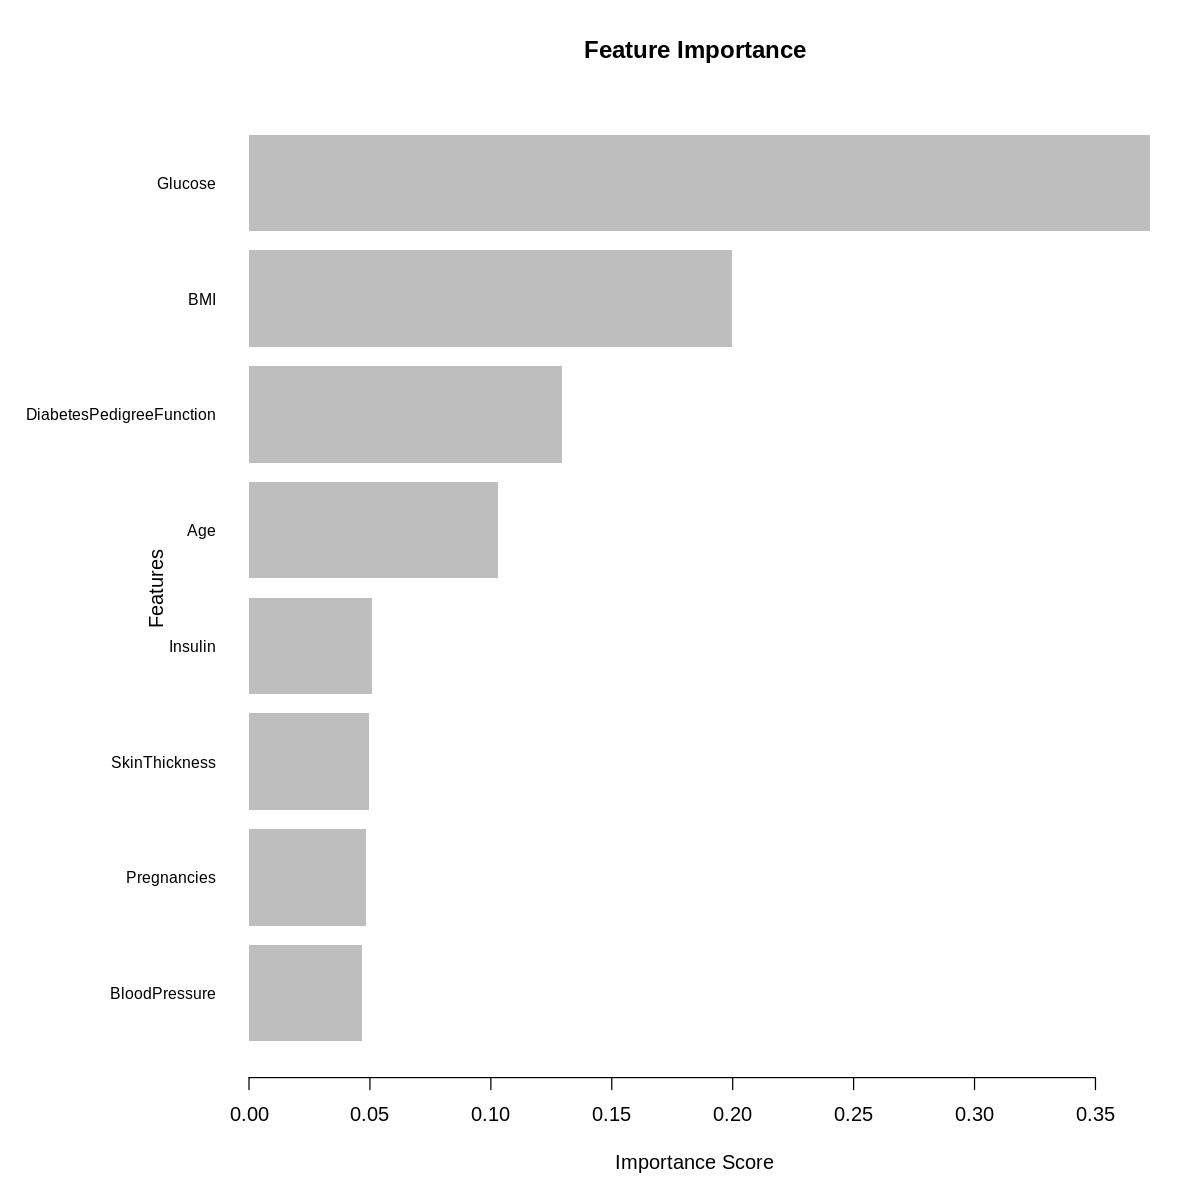

In [73]:
# plot feature importance
importance_matrix <- xgb.importance(feature_names = colnames(X_train), model = model)

# Plot feature importance
xgb.plot.importance(importance_matrix,
                     main = "Feature Importance",
                     xlab = "Importance Score",
                     ylab = "Features")

The results should indicate that Body Mass or a family history of Diabeties or Glucose levels contribute the most the prediction of Diabeties in this model.

 **Note:** Due to the to small size of this example data set and the randomization used making a training and test set the order of improtance could very in different runs.

Larger sets are needed for reproducible machine learning.

# **Credits**

**The END** <br>
**Authors: Dr. Samir Gupta, Dr. Matthew McCoy, Jia Li Dong (M.S.) & ICBI AIM-AHEAD Team**

<img src="https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/HIDSLOGO.AA1.jpg" alt="Powered by" width="500"/>

